# Gender Pay Gap Dataset
## Kasprzak Jakub, Lis Jakub, Majczyk Adam 

In [1]:
import pandas as pd
import numpy as np
import dalex

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

import xgboost as xgb

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

from sklearn.model_selection import train_test_split

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## KM1 - EDA

Analizowany zbiór danych pochodzi ze strony https://www.kaggle.com/fedesoriano/gender-pay-gap-dataset. Zawarte tam są dwie tabele:
* the Panel Study of Income Dynamics (PSID), dane pochodzące z okresu 1980-2010,
* the Current Population Survey (CPS), aktualne dane, zapewniające dodatkowe informacje nt. zróżnicowania wynagrodzenia ze względu na płeć.

W opisie danych na podanej wyżej stronie można przeczytać również skrótowe opisy większości kolumn.

In [2]:
# wczytanie danych
psid = pd.read_csv('PanelStudyIncomeDynamics.csv')
cps = pd.read_csv('CurrentPopulationSurvey.csv')

# Analiza ramki PSID (dane historyczne 1980-2010)

Tabela PSID zawiera 274 kolumny i 33398 wiersze

In [3]:
psid.shape

(33398, 274)

In [4]:
psid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33398 entries, 0 to 33397
Columns: 274 entries, intnum68 to LEHS
dtypes: float64(121), int64(152), object(1)
memory usage: 69.8+ MB


Sprawdzamy kolumny, w których występują braki danych.

In [5]:
psid.isnull().sum()[psid.isnull().sum()>0].sort_values(ascending=False)

origschHD          33398
origschWF          33398
origannWeeksWFR    28787
origrace           28787
origannWeeksHDR    28787
                   ...  
smsa                  33
potexp                25
potexp2               25
sch                   25
region                 3
Length: 95, dtype: int64

Przed analizą pozbędziemy się kolumn, w których te braki wynoszą więcej niż 40%.

In [6]:
toDrop = psid.isnull().sum()[psid.isnull().sum()/len(psid) > 0.4]
psid = psid.drop(list(toDrop.index), axis=1)
psid.shape

(33398, 237)

Dodatkowo usuniemy kolumny, które przyjmują tylko jedną wartość - nie wnoszą one nic do naszych danych.

In [7]:
col_names = psid.columns
for col in col_names:
    if len(psid[col].unique()) == 1:
        psid = psid.drop(col,axis=1)

Wśród kolumn mamy też takie, które przyjmują jedną zawsze tę samą wartość lub NaN. Te kolumn są nieinterpretowalne, ponieważ nie zostały opisane na kagglu.

In [8]:
psid = psid.drop(list(psid.filter(regex=("origstop.*")).columns), axis = 1)

In [9]:
psid.shape

(33398, 209)

In [10]:
psid.describe().T # podstawowe statystyki dla kazdej z kolumn

,count,mean,std,min,25%,50%,75%,max
intnum68,33398.0,2942.203964,2198.106202,4.0,1152.0,2210.0,5464.00,6872.0
pernum68,33398.0,75.144260,81.071224,1.0,4.0,30.0,172.00,262.0
wave,33398.0,2000.293221,10.536950,1981.0,1990.0,2007.0,2009.00,2011.0
sex,33398.0,1.513863,0.499815,1.0,1.0,2.0,2.00,2.0
intnum,33398.0,3935.475058,2267.144304,1.0,2034.0,3854.5,5732.75,8940.0
...,...,...,...,...,...,...,...,...
farmer,33398.0,0.005659,0.075014,0.0,0.0,0.0,0.00,1.0
constructextractinstall,33398.0,0.080544,0.272137,0.0,0.0,0.0,0.00,1.0
production,33398.0,0.097880,0.297157,0.0,0.0,0.0,0.00,1.0
transport,33398.0,0.071771,0.258112,0.0,0.0,0.0,0.00,1.0


![alt text](gigamacierz.jpg "Title")

In [11]:
highCorelPsid = psid.corr()['realhrwage'].abs().sort_values(ascending = False)

In [12]:
highCorelPsid

realhrwage         1.000000
hrwage             0.968936
annlabinc          0.833967
lnrealwg           0.761161
origannLabIncHD    0.634442
                     ...   
wtrgov             0.004658
origannWeeksHD     0.004273
origrelHead        0.003644
ind2               0.001430
Education          0.000038
Name: realhrwage, Length: 208, dtype: float64

Usuniemy na sam początek kolumny, które mają najmniejszą (co do modułu) korelację z realhrwage.

In [13]:
toDropListHighCorel =[]
for (i, j) in highCorelPsid.iteritems():
    if (j < 0.1):
        toDropListHighCorel.append(i)

In [14]:
psid = psid.drop(toDropListHighCorel, axis = 1)
psid.shape

(33398, 58)

<AxesSubplot:>

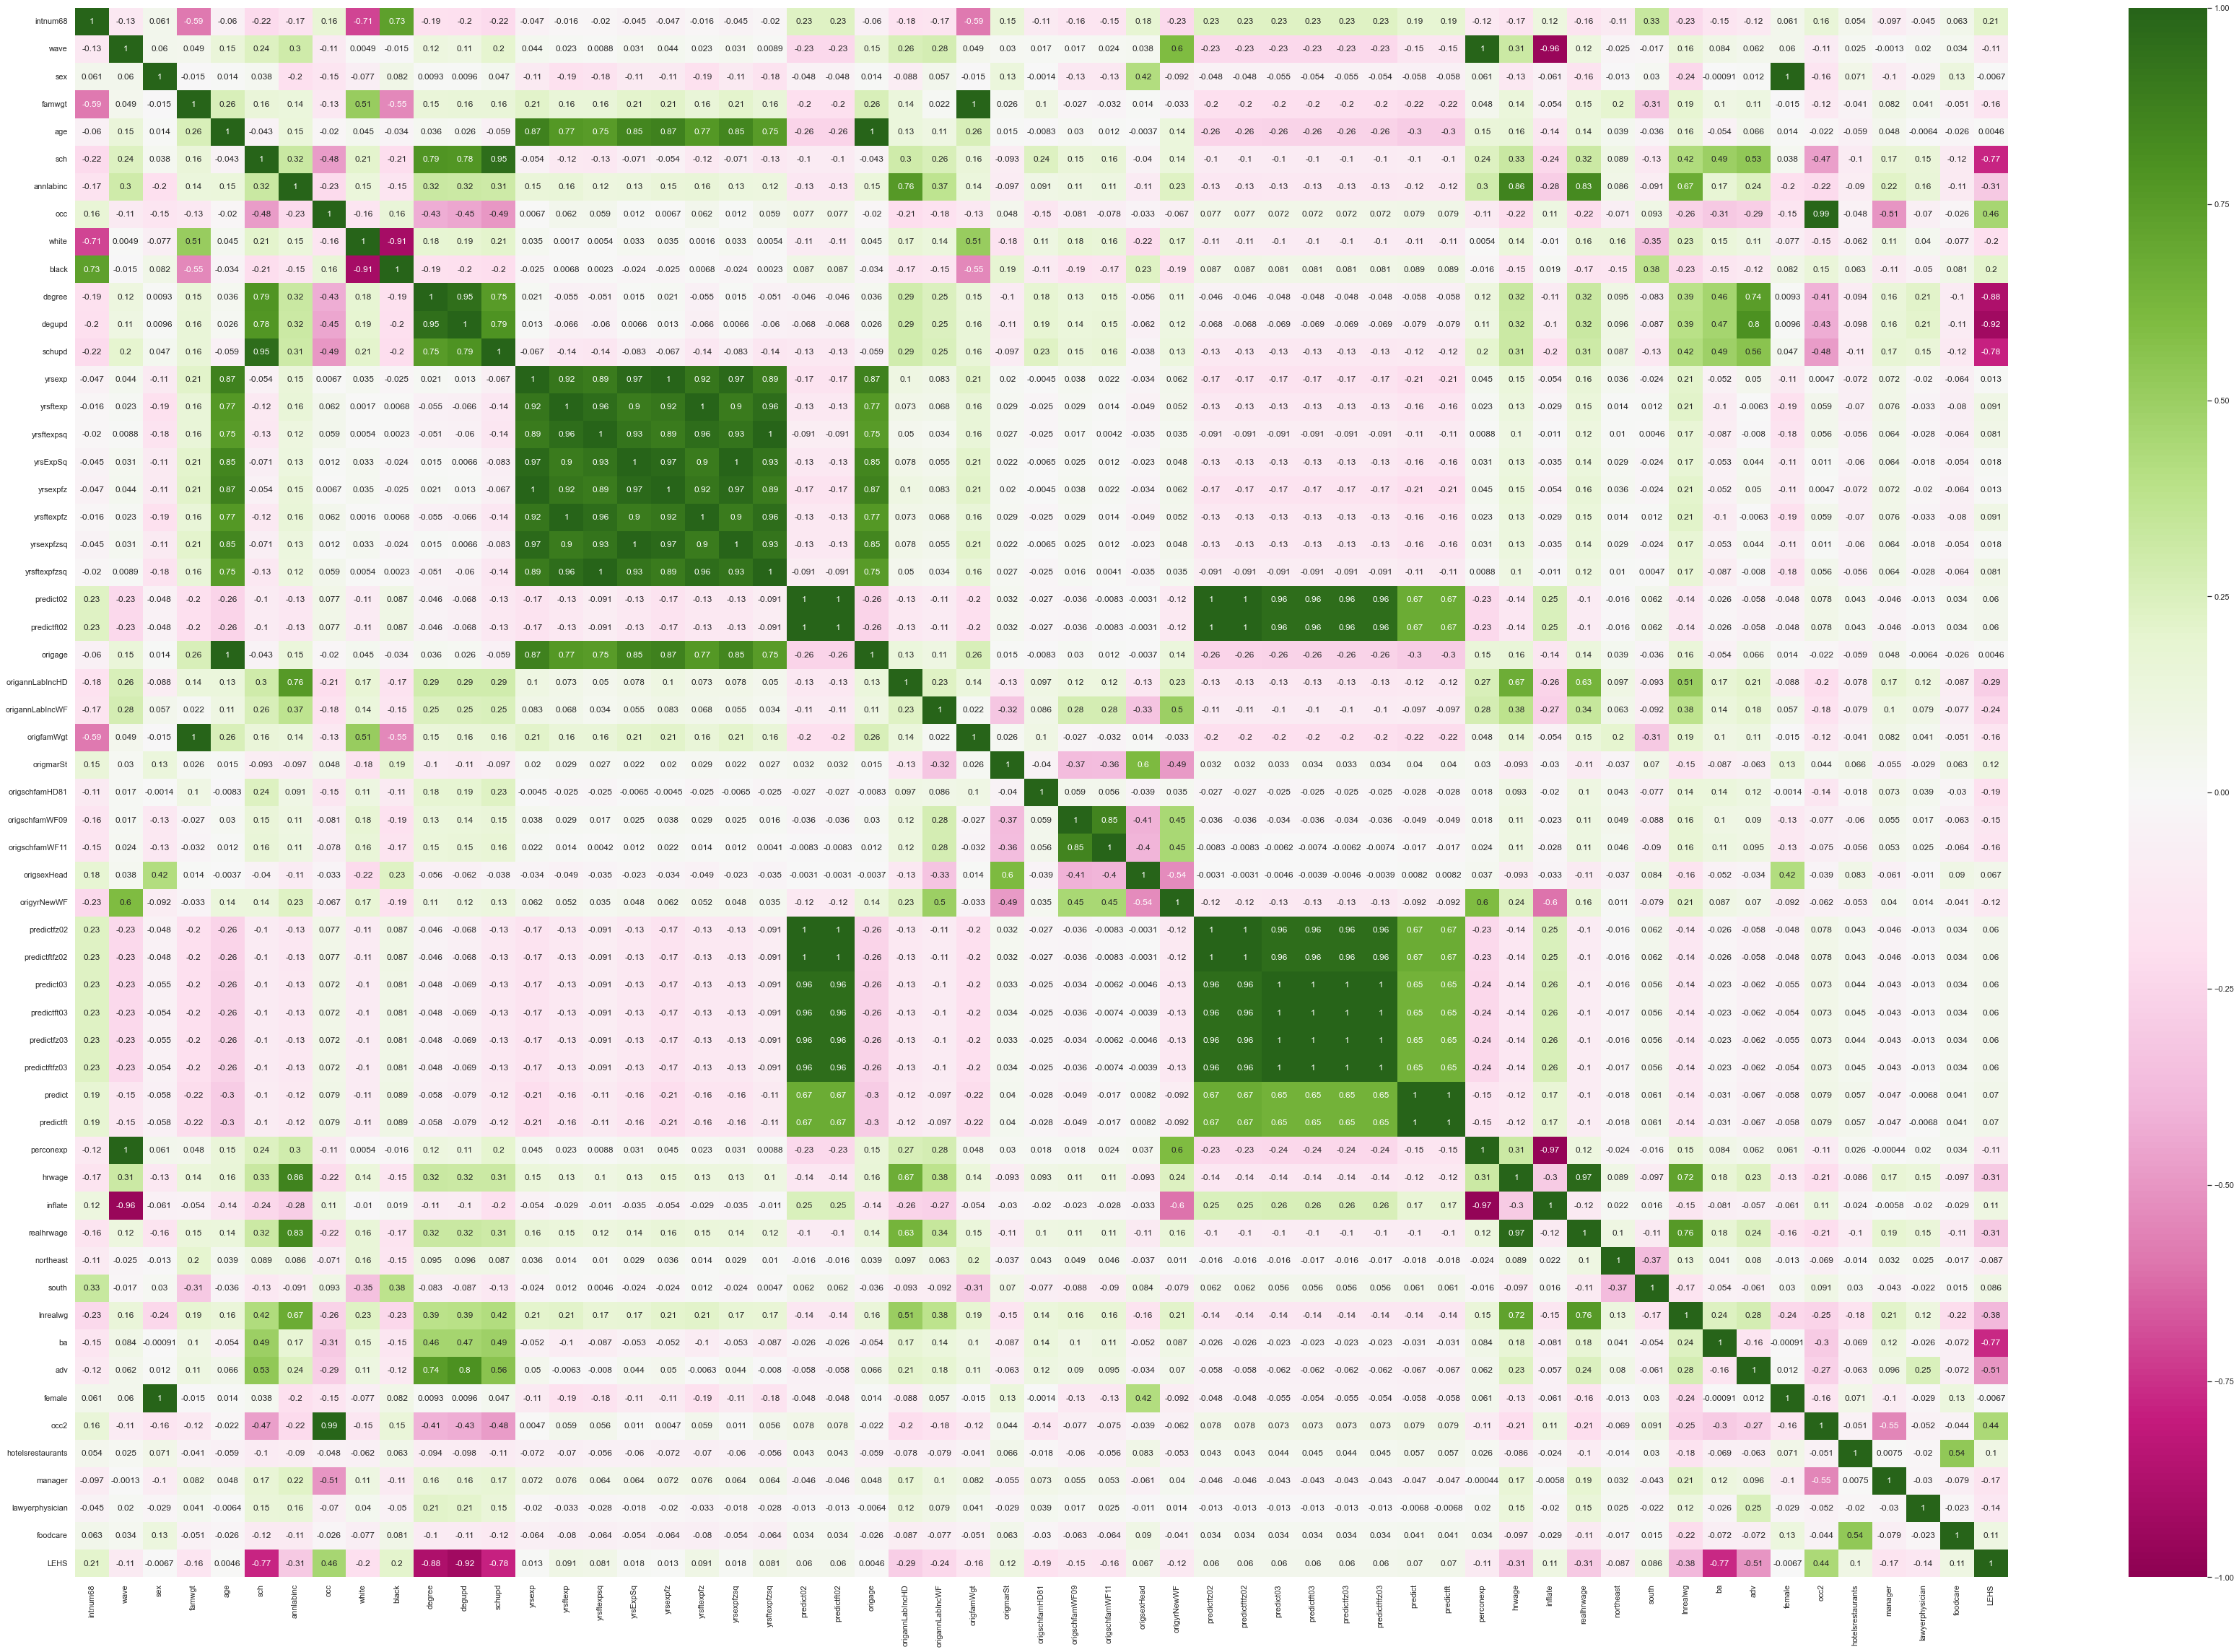

In [15]:
sns.set(rc = {'figure.figsize':(60,40)})
sns.heatmap(psid.corr(), 
        xticklabels=psid.corr().columns,
        yticklabels=psid.corr().columns, 
        annot = True, 
        vmin = -1, vmax = 1,
        cmap="PiYG")

In [15]:
# Usuwamy silnie skorelowane ze sobą zmienne, wszystkie odnoszące się do lat doświadczenia 
# zostawiamy jedną z nich: yrsexp
psid = psid.drop(columns=['yrsftexp', 'yrsftexpsq', 'yrsExpSq', 'yrsexpfz', 
                          'yrsftexpfz', 'yrsexpfzsq', 'yrsftexpfzsq'])

In [16]:
# zostawiamy predict, predict03
psid = psid.drop(columns=['predict02', 'predictft02', 'predictfz02', 'predictftfz02',
                          'predictft03', 'predictfz03', 'predictftfz03', 'predictft'])

In [17]:
# zostawiamy sch, degree
psid = psid.drop(columns=['degupd', 'schupd'])

In [18]:
# dalej wywalamy skorelowane ze soba zmienne lub slabo opisane
psid = psid.drop(columns=['black', 'origage', 'ba', 'adv', 'origfamWgt', 'origmarSt', 'female', 'occ2', 
                          'inflate', 'origschfamHD81', 'origschfamWF09', 'origschfamWF11', 'origsexHead'])

In [20]:
psid.columns

Index(['intnum68', 'wave', 'sex', 'famwgt', 'age', 'sch', 'annlabinc', 'occ',
       'white', 'degree', 'yrsexp', 'origannLabIncHD', 'origannLabIncWF',
       'origyrNewWF', 'predict03', 'predict', 'perconexp', 'hrwage',
       'realhrwage', 'northeast', 'south', 'lnrealwg', 'occ2name',
       'hotelsrestaurants', 'manager', 'lawyerphysician', 'foodcare', 'LEHS'],
      dtype='object')

In [19]:
psid = psid.drop(columns=['wave', 'LEHS', 'hrwage', 'intnum68', 'annlabinc', 'lnrealwg'])

Końcowa macierz korelacji po usunięciu zmiennych.

<AxesSubplot:>

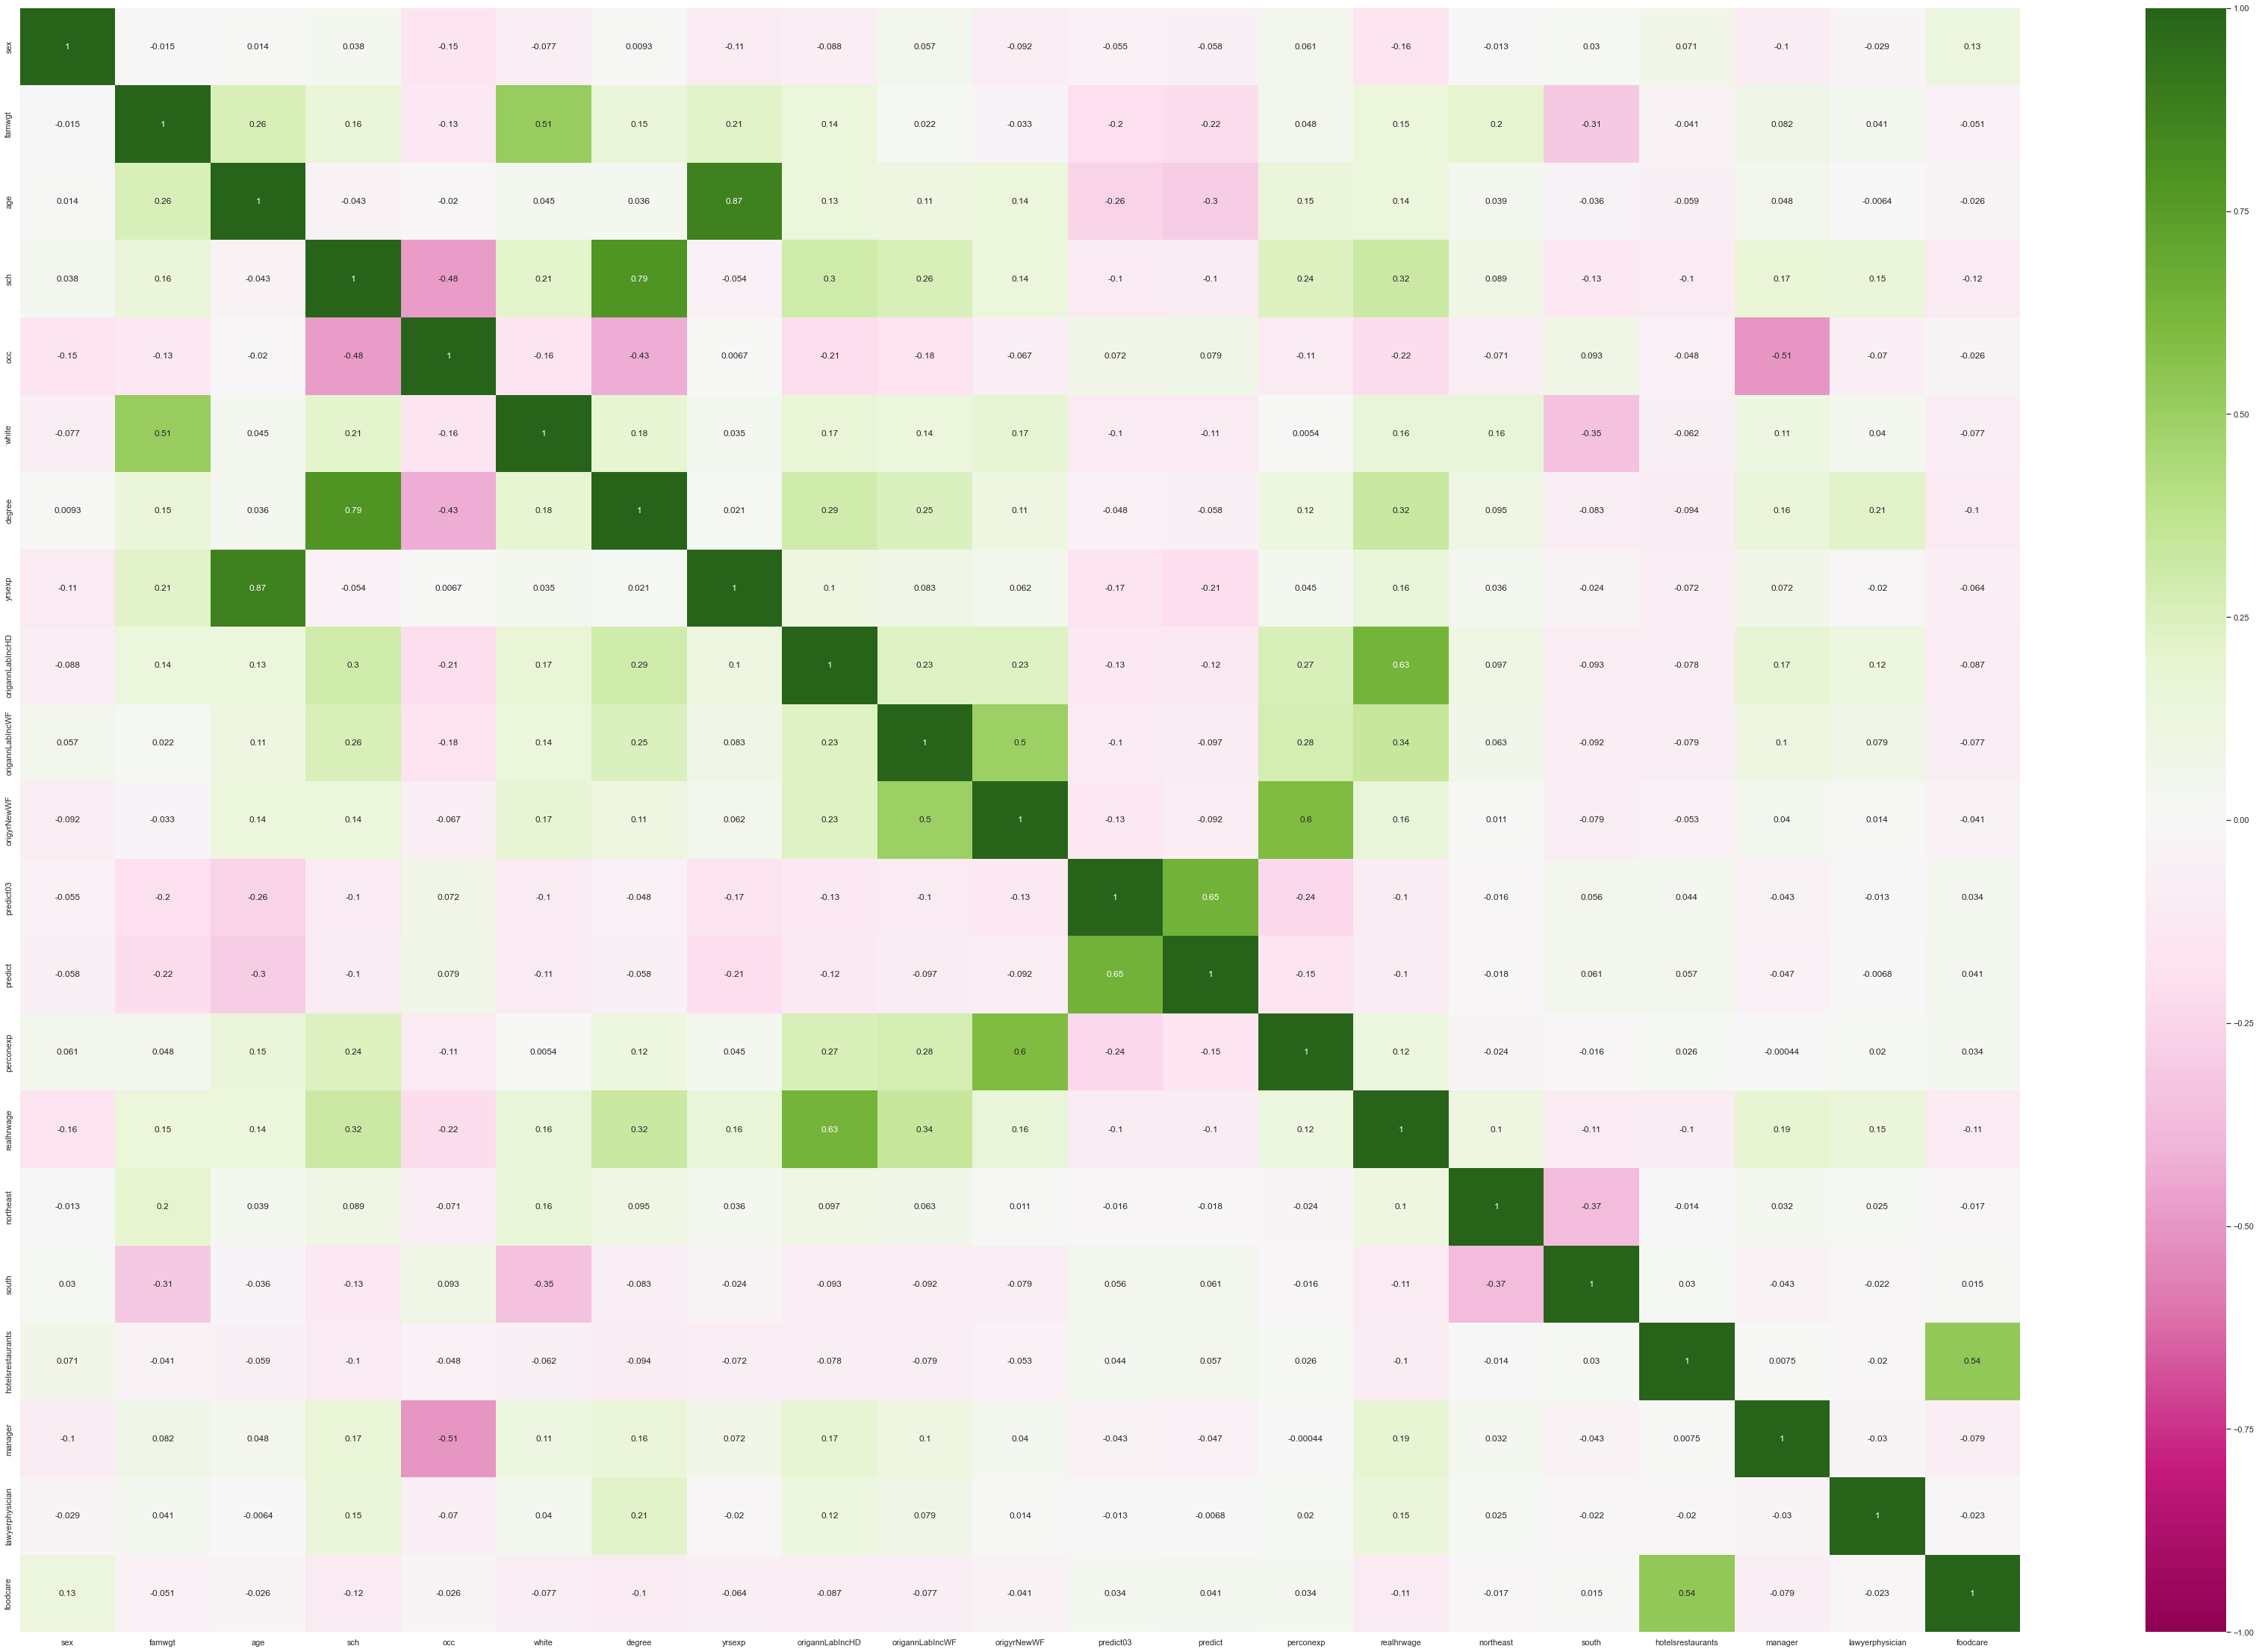

In [22]:
sns.set(rc = {'figure.figsize':(60,40)})
sns.heatmap(psid.corr(), 
        xticklabels=psid.corr().columns,
        yticklabels=psid.corr().columns, 
        annot = True, 
        vmin = -1, vmax = 1,
        cmap="PiYG")

In [23]:
psid_without_outliers = psid.loc[psid.realhrwage <= 100]

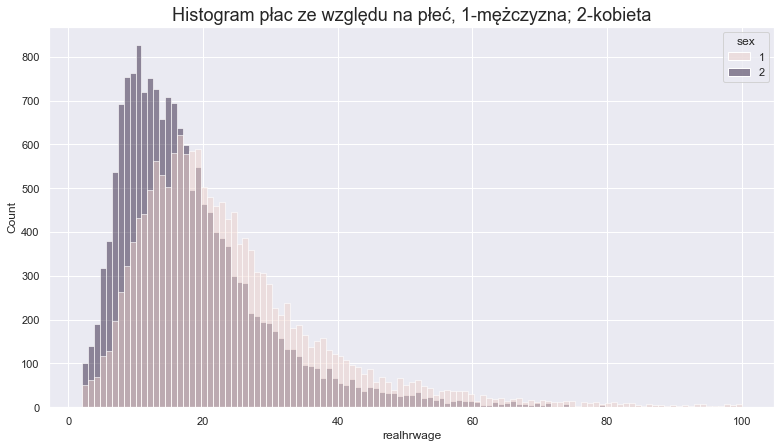

In [24]:
fig, ax = plt.subplots(figsize=(13,7))
sns.histplot(x='realhrwage', hue='sex', data=psid_without_outliers)
plt.title("Histogram płac ze względu na płeć, 1-mężczyzna; 2-kobieta", size=18)
plt.show()

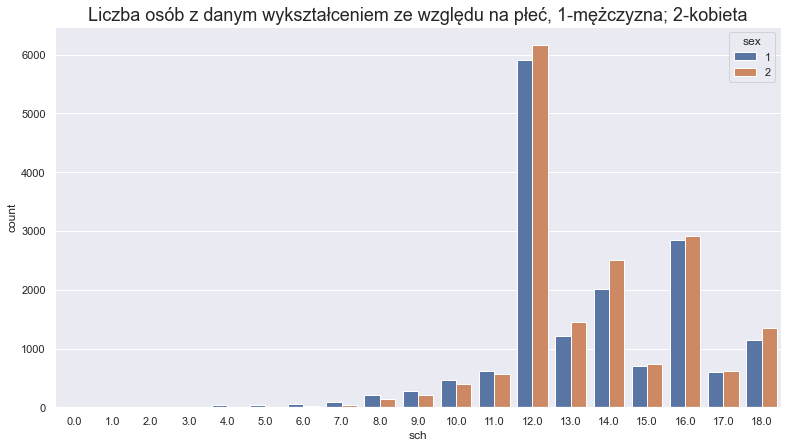

In [25]:
fig, ax = plt.subplots(figsize=(13,7))
sns.countplot(x='sch', hue='sex', data=psid)
plt.title("Liczba osób z danym wykształceniem ze względu na płeć, 1-mężczyzna; 2-kobieta", size=18)
plt.show()

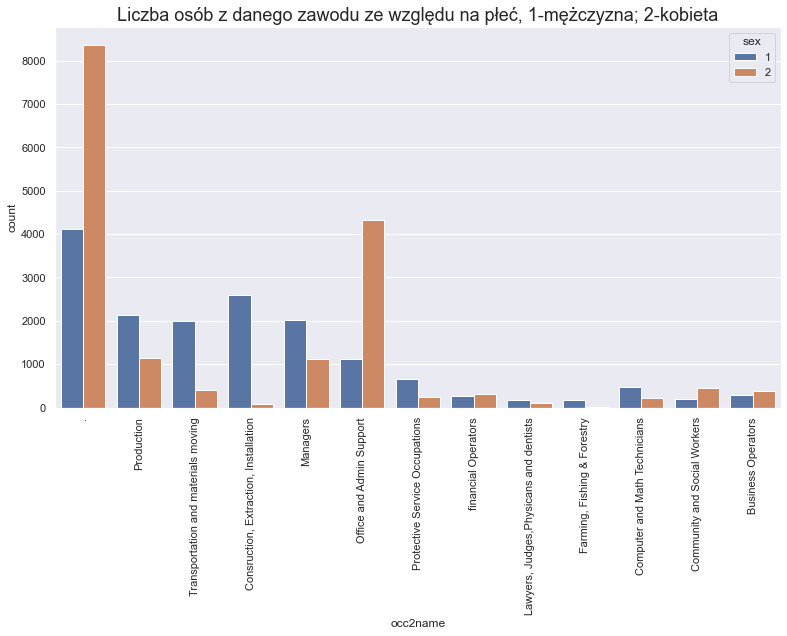

In [26]:
fig, ax = plt.subplots(figsize=(13,7))
sns.countplot(x='occ2name', hue='sex', data=psid)
plt.title("Liczba osób z danego zawodu ze względu na płeć, 1-mężczyzna; 2-kobieta", size=18)
plt.xticks(rotation=90)
plt.show()

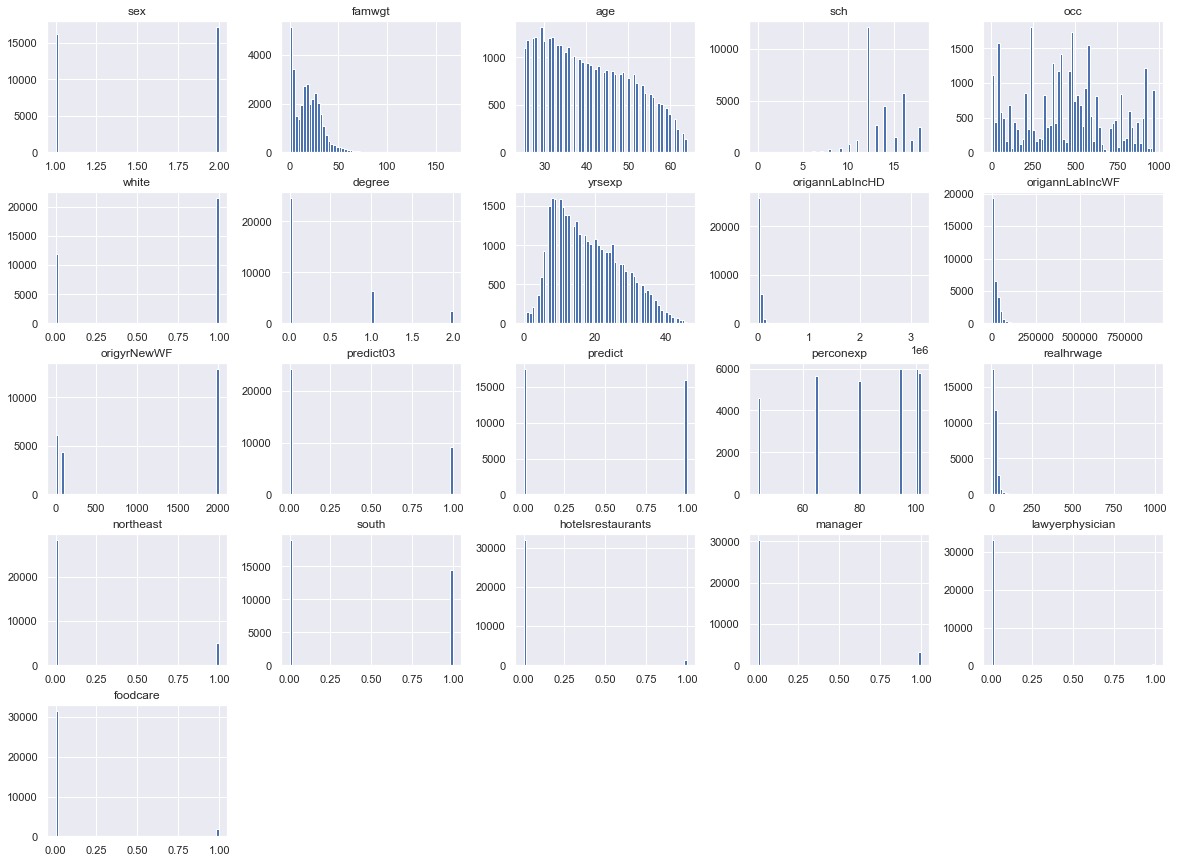

In [27]:
psid.hist(bins = 60, figsize=(20, 15))
plt.show()

Wnioski:
* occ wygląda dosyć losowo
* age ma rozkład zbliżony do normalnego (do fragmentu - prawej strony)
* realhrwage ma skośny rozkład - może jakiś logarytm
* occ50ly jest multimodalny - może rozbić na kilka zmiennych
* origannLabIncWF, origannLabIncHD, famwgt mają skośne rozkłady - może jakiś logarytm

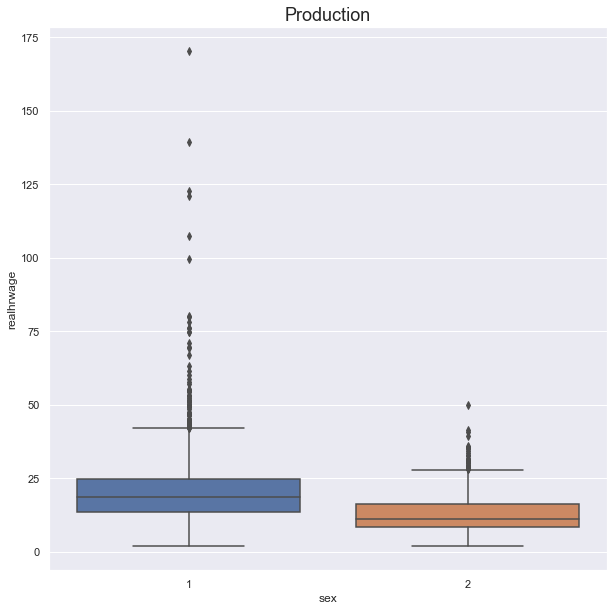

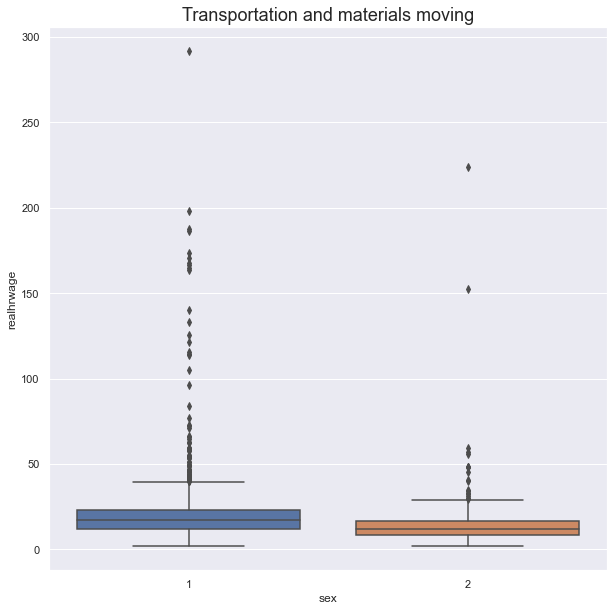

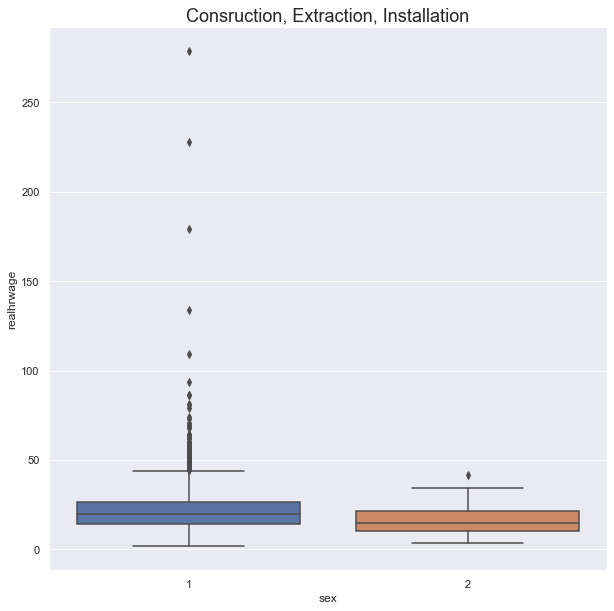

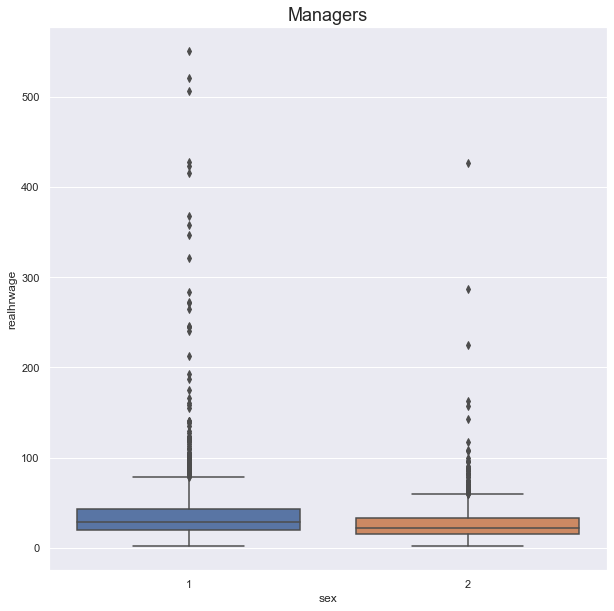

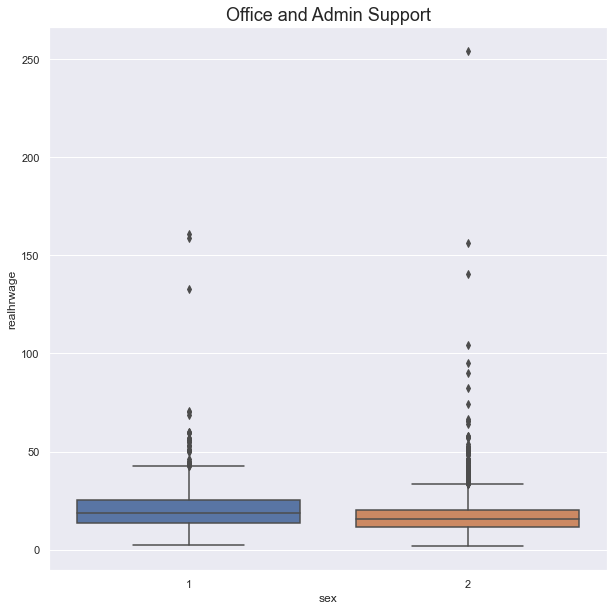

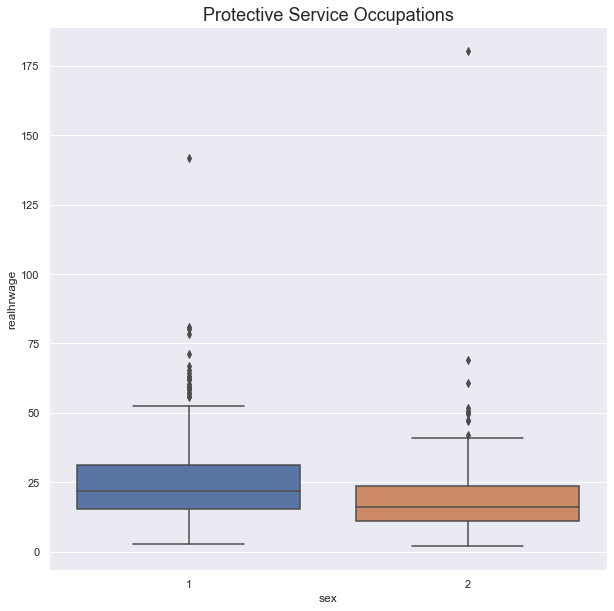

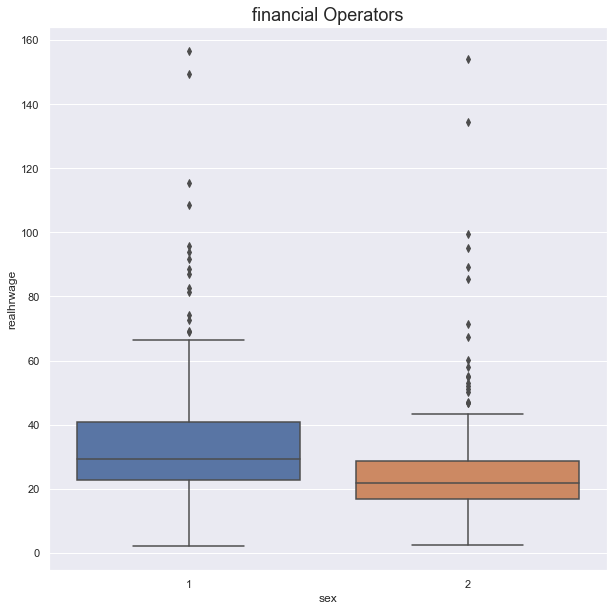

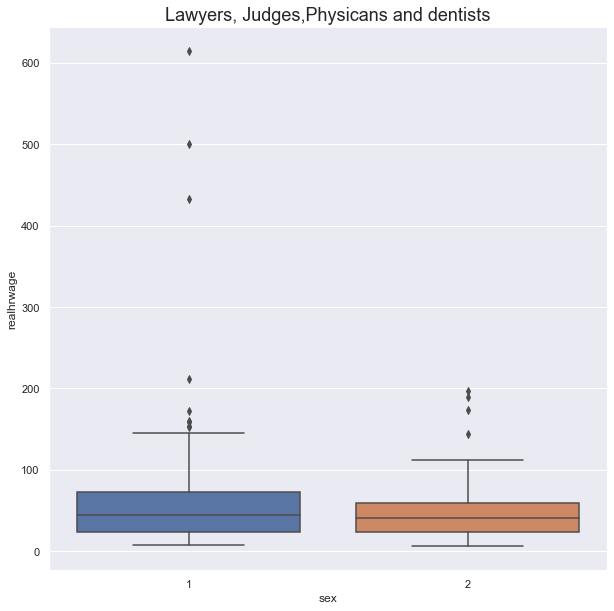

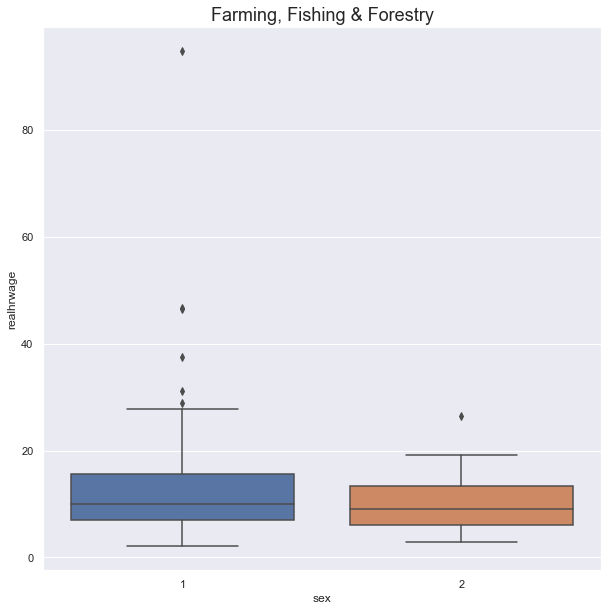

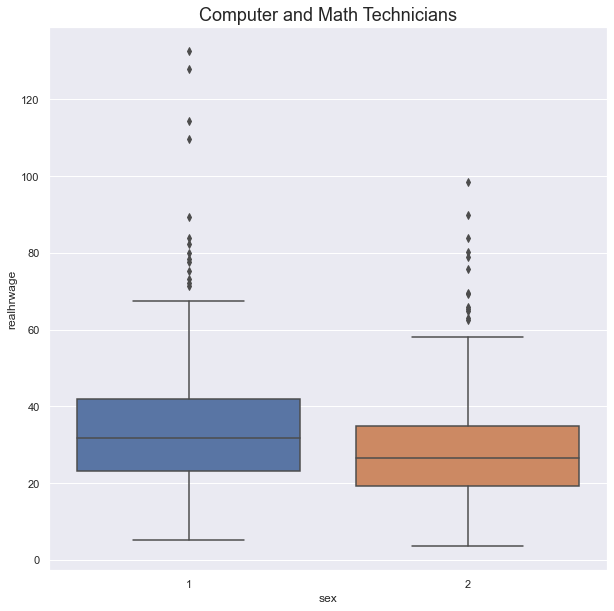

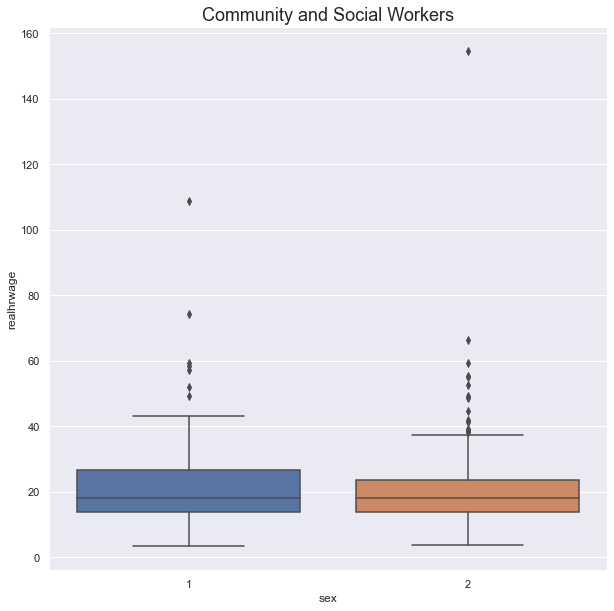

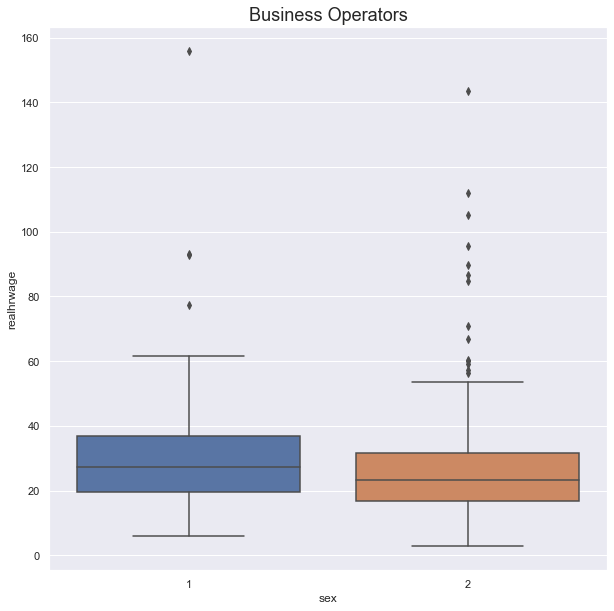

In [28]:
sns.set(rc = {'figure.figsize':(10,10)})

for occ in psid.occ2name.unique()[1:]:
    tmp = psid.loc[psid.occ2name == occ]
    sns.boxplot(x='sex', y='realhrwage', data=tmp)
    plt.title(occ, size=18)
    plt.show()


Wnioski - jest dużo outlierów - może jakiś logarytm.

# Analiza ramki CPS (dane nowe)

In [20]:
cps.shape

(344287, 234)

In [21]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344287 entries, 0 to 344286
Columns: 234 entries, year to LEHS
dtypes: float64(85), int64(146), object(3)
memory usage: 614.6+ MB


Sprawdzamy kolumny, w których występują braki danych.

In [22]:
cps.isnull().sum()[cps.isnull().sum()>0].sort_values(ascending=False)

unmatched_occ_90     344287
unmatched_occ_99     344287
unmatched_fem_81     344287
unmatched_male_81    344287
unmatched_ind_99     344287
                      ...  
hrswork               10555
metro                  9759
hispan                 1397
ind1990                 181
ind50ly                  65
Length: 68, dtype: int64

Przed analizą pozbędziemy się kolumn, w których te braki wynoszą więcej niż 40%.

In [23]:
toDrop = cps.isnull().sum()[cps.isnull().sum()/len(cps) > 0.4]
cps = cps.drop(list(toDrop.index), axis=1)
cps.shape

(344287, 202)

Dodatkowo usuniemy kolumny, które przyjmują tylko jedną wartość - nie wnoszą one nic do naszych danych.

In [24]:
col_names = cps.columns
for col in col_names:
    if len(cps[col].unique()) == 1:
        cps = cps.drop(col,axis=1)

Wśród kolumn mamy też takie, które przyjmują jedną zawsze tę samą wartość lub NaN. Te kolumn są nieinterpretowalne, ponieważ nie zostały opisane na kagglu.

In [25]:
cps = cps.drop(["qinclong", "qsrcearn"], axis = 1)

In [30]:
np.mean(cps['realhrwage'])

22.886629395171123

In [31]:
cps.describe().T # podstawowe statystyki dla kazdej z kolumn

,count,mean,std,min,25%,50%,75%,max
year,344287.0,2002.599122,10.831555,1981.0,1990.000000,2007.000000,2011.00000,2013.000000
serial,344287.0,44774.129758,26722.907094,1.0,21980.000000,43297.000000,66479.00000,98095.000000
numprec,344287.0,3.225141,1.508176,1.0,2.000000,3.000000,4.00000,16.000000
hwtsupp,344287.0,1507.300236,907.232381,0.0,818.505005,1473.829956,1935.98999,13310.929688
region,344287.0,27.752070,10.809778,11.0,21.000000,31.000000,41.00000,42.000000
...,...,...,...,...,...,...,...,...
farmer,344287.0,0.006855,0.082509,0.0,0.000000,0.000000,0.00000,1.000000
constructextractinstall,344287.0,0.088818,0.284482,0.0,0.000000,0.000000,0.00000,1.000000
production,344287.0,0.086358,0.280893,0.0,0.000000,0.000000,0.00000,1.000000
transport,344287.0,0.061800,0.240793,0.0,0.000000,0.000000,0.00000,1.000000


![alt text](gigamacierzalemniejsza.png "Title")

In [27]:
highCorelCps = cps.corr()['realhrwage'].abs().sort_values(ascending = False)

In [28]:
highCorelCps

realhrwage            1.000000
uncenrealhrwage       1.000000
hrwage                0.999919
un_lnrealwg           0.060668
lnrwg                 0.060668
                        ...   
o_classwkr            0.000102
classwkr              0.000102
miningconstruction    0.000059
adj_ind2              0.000051
protective            0.000031
Name: realhrwage, Length: 176, dtype: float64

In [29]:
toDropListHighCorel =[]
for (i, j) in highCorelCps.iteritems():
    if (j < 0.005):
        toDropListHighCorel.append(i)

In [30]:
cps = cps.drop(toDropListHighCorel, axis = 1)
cps.shape

(344287, 50)

In [31]:
# usuwamy zmienne, które są już reprezentowane przez zmienne bez przedrostku o_
cps = cps.drop(list(cps.filter(regex=("^(o_).*")).columns), axis =1 ) 

In [32]:
# usuwamy zmienne namnażające informacje o edukacji, zarobkach, ciągłości pracy
cps = cps.drop(["educ99", "female", "adj_occ2", "un_lnrealwg", "lnrwg", "uncenrealhrwage", "hrwage", "incwageman", "niincwage", "inclongj", "incwage"],axis =1 ) 

In [33]:
cps = cps.drop(['wkswork2', 'occ1990', 'occ1950', 'educorig', 'LEHS'],axis =1 ) 

In [34]:
cps = cps.drop([ 'perconexp', 'adv', 'ba','tcinclongj', 'tcincwage', 'inflate' ],axis =1 ) 

<AxesSubplot:>

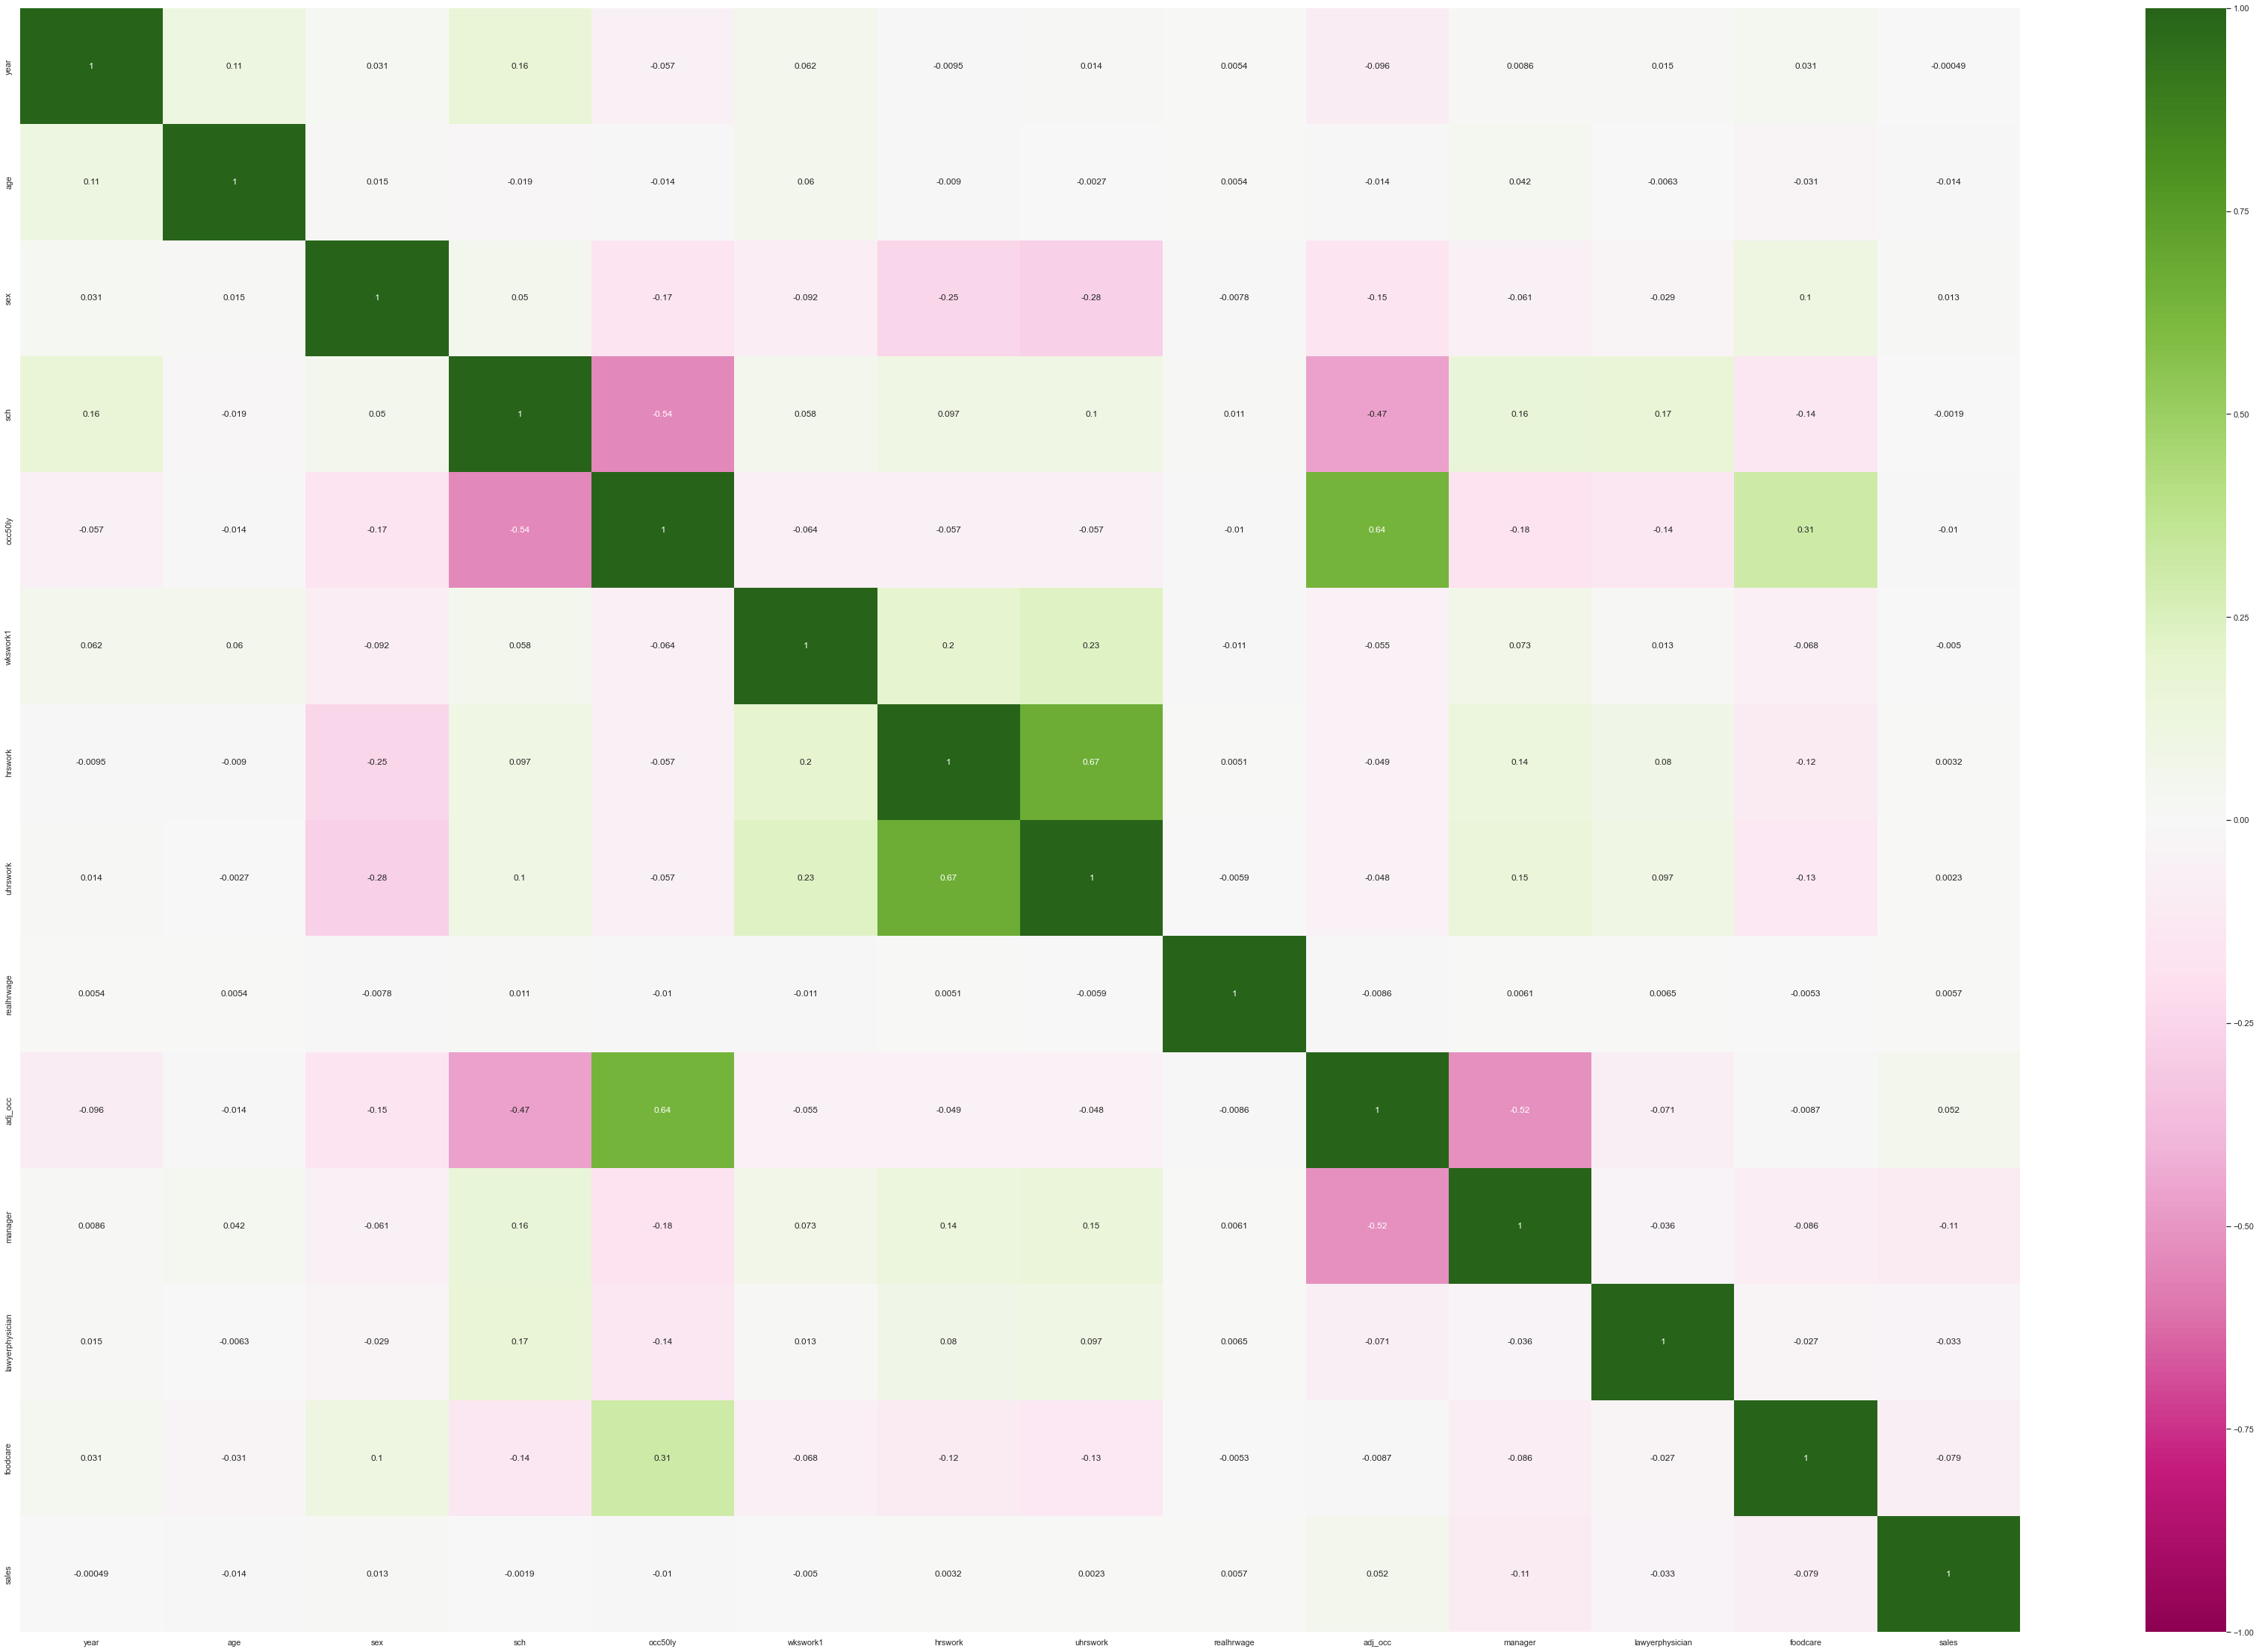

In [35]:
sns.set(rc = {'figure.figsize':(60,40)})
sns.heatmap(cps.corr(), 
        xticklabels=cps.corr().columns,
        yticklabels=cps.corr().columns, 
        annot = True, 
        vmin = -1, vmax = 1,
        cmap="PiYG")

In [46]:
cps_without_outliers = cps.loc[cps.realhrwage <= 100]

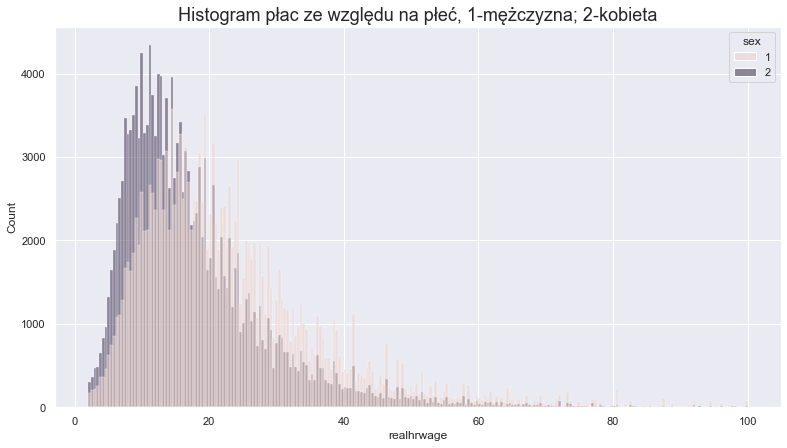

In [47]:
fig, ax = plt.subplots(figsize=(13,7))
sns.histplot(x='realhrwage', hue='sex', data=cps_without_outliers)
plt.title("Histogram płac ze względu na płeć, 1-mężczyzna; 2-kobieta", size=18)
plt.show()

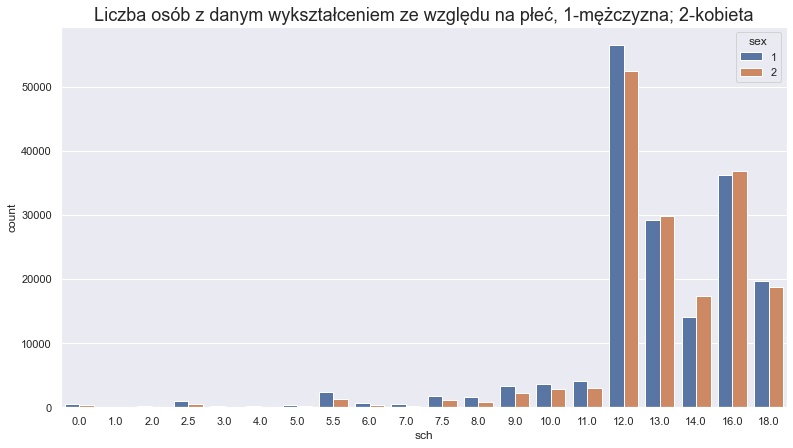

In [48]:
fig, ax = plt.subplots(figsize=(13,7))
sns.countplot(x='sch', hue='sex', data=cps)
plt.title("Liczba osób z danym wykształceniem ze względu na płeć, 1-mężczyzna; 2-kobieta", size=18)
plt.show()

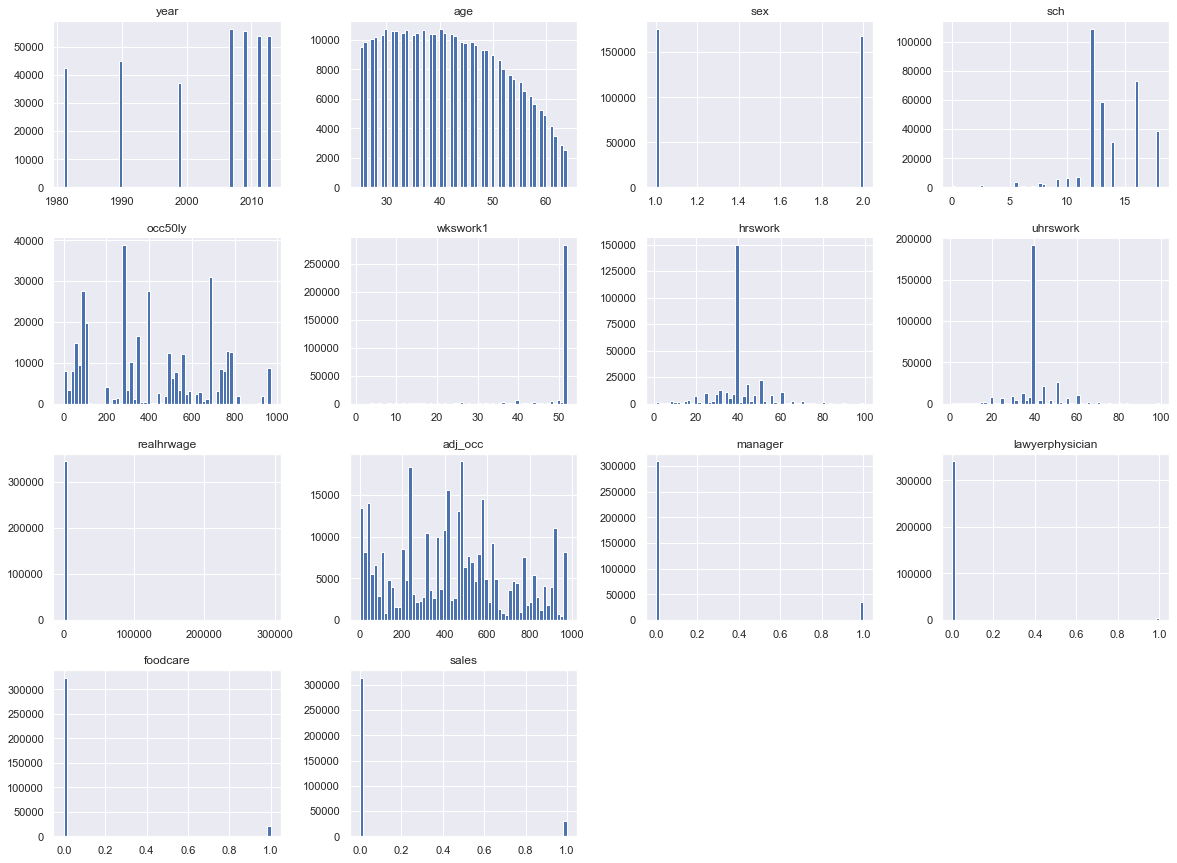

In [49]:
cps.hist(bins = 60, figsize=(20, 15))
plt.show()

Wnioski:
* adj_occ wygląda dosyć losowo
* wiekszość ludzi pracuje 40h
* age ma rozkład zbliżony do normalnego
* incwage ma skośny rozkład - może jakiś logarytm
* occ50ly jest multimodalny - może rozbić na kilka zmiennych

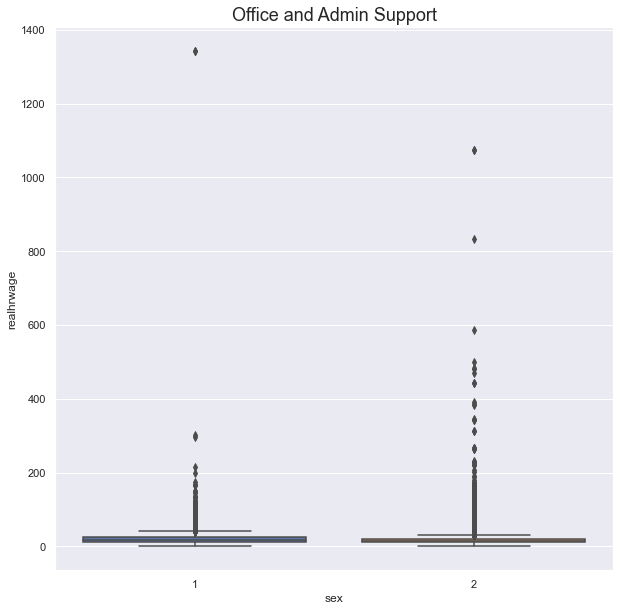

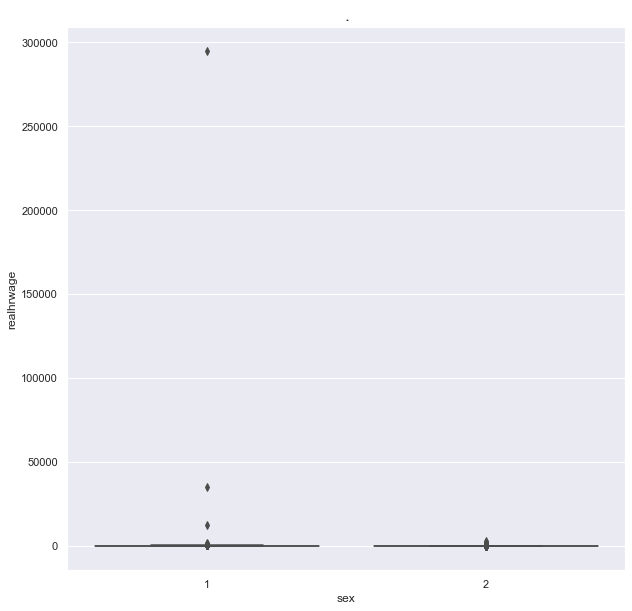

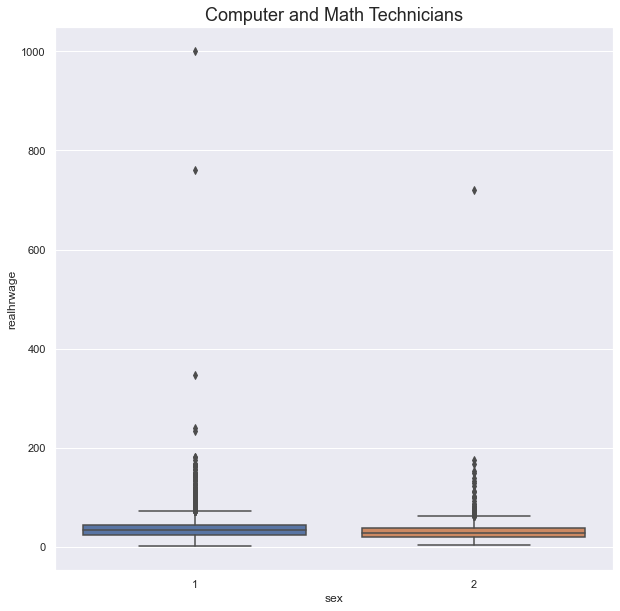

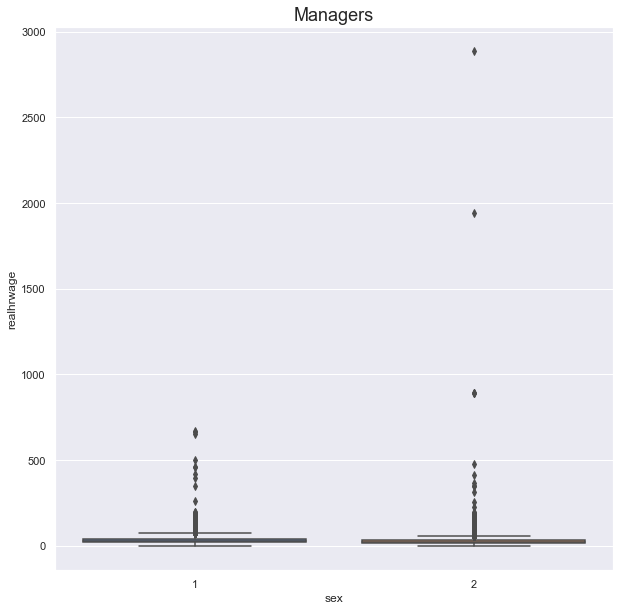

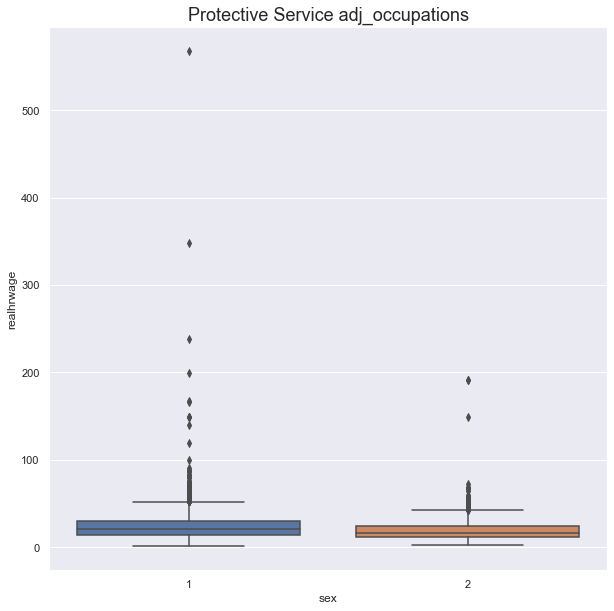

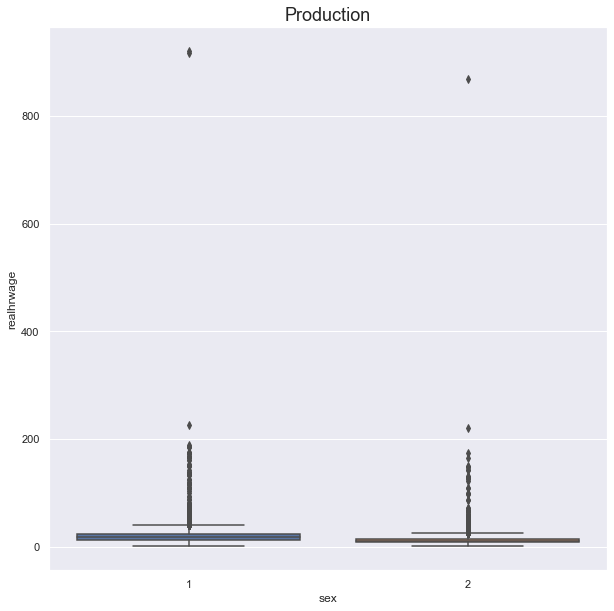

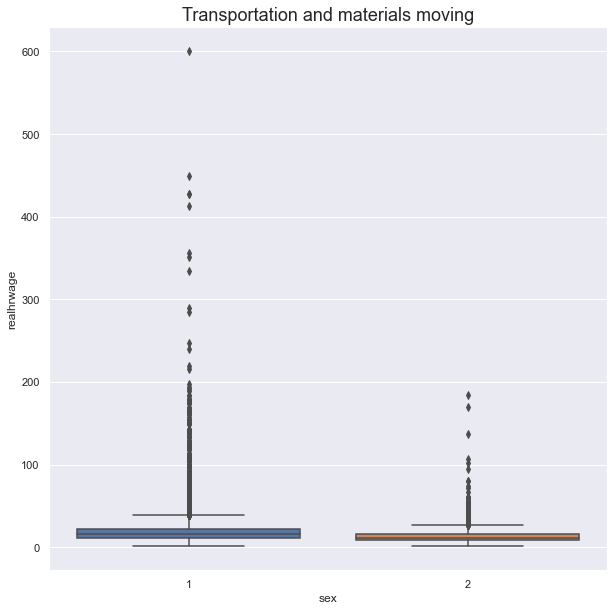

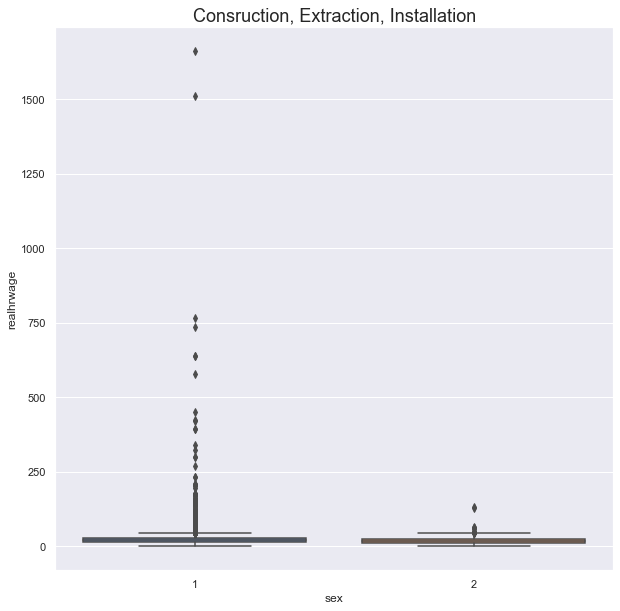

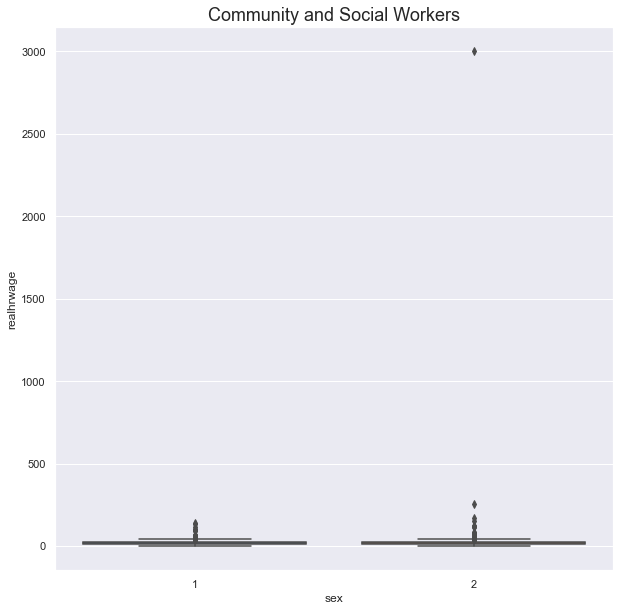

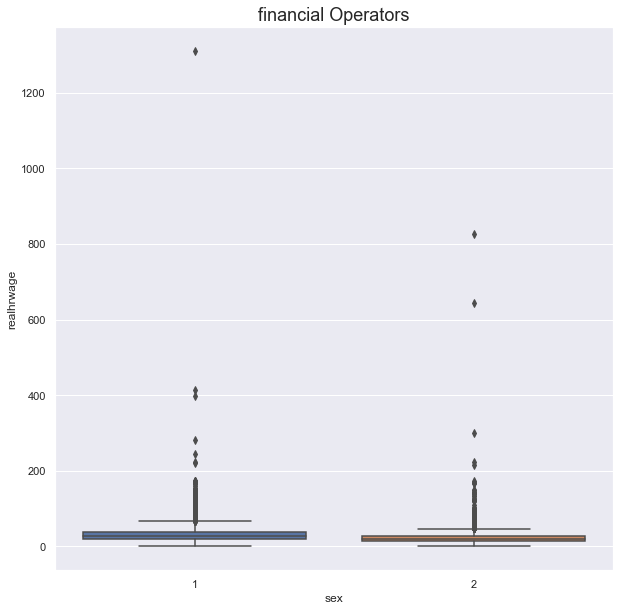

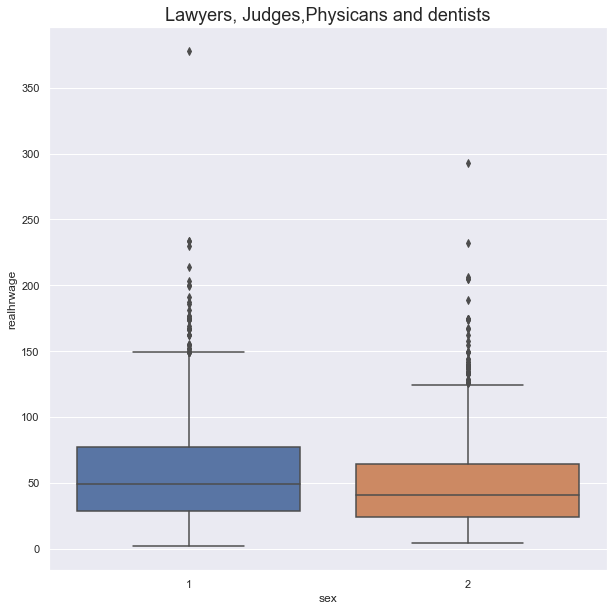

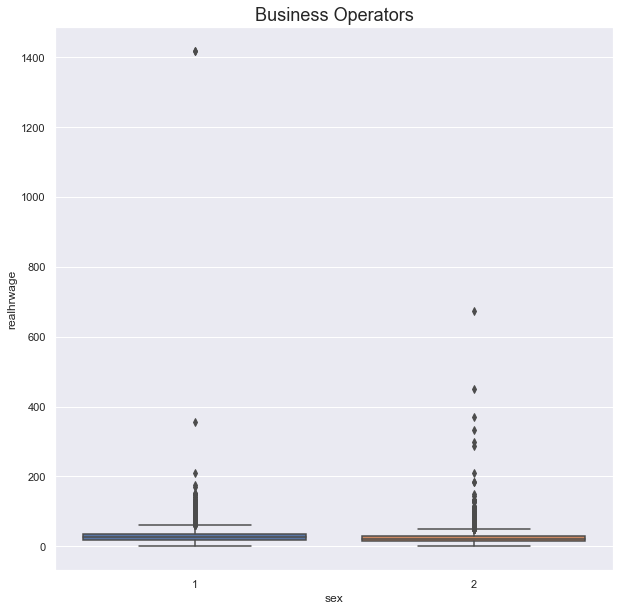

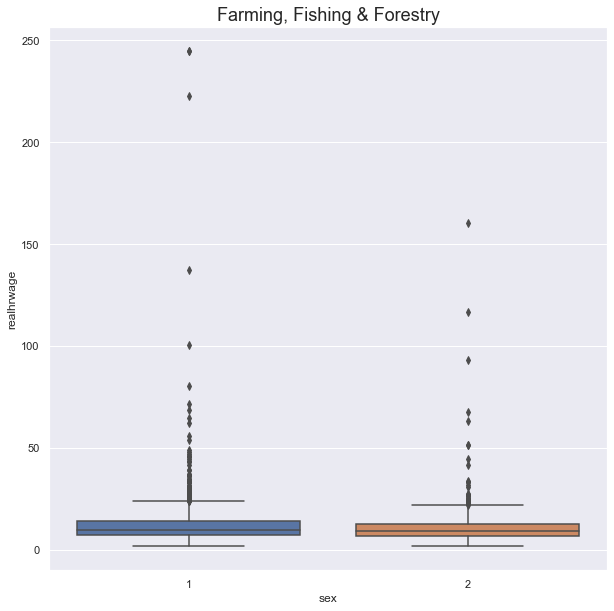

In [50]:
sns.set(rc = {'figure.figsize':(10,10)})

for occ in cps.adj_occ2name.unique():
    tmp = cps.loc[cps.adj_occ2name == occ]
    sns.boxplot(x='sex', y='realhrwage', data=tmp)
    plt.title(occ, size=18)
    plt.show()


Wnioski - jest dużo outlierów - może jakiś logarytm.

## KM2 - modyfikacja danych + modele
## Gender Pay Gap Dataset
### Kasprzak Jakub, Lis Jakub, Majczyk Adam 


#### Przygotowanie danych

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(psid[['occ2name']]).toarray())

#merge one-hot encoded columns back with original DataFrame
psid = psid.join(encoder_df)

encoder_df = pd.DataFrame(encoder.fit_transform(cps[['adj_occ2name']]).toarray())

#merge one-hot encoded columns back with original DataFrame
cps = cps.join(encoder_df)

In [37]:
psid = psid.drop(columns = ['occ2name'])
cps = cps.drop(columns = ['adj_occ2name'])

In [38]:
psid = psid.drop(columns = ['origyrNewWF'])

In [39]:
psid = psid.fillna(psid.median())
cps = cps.fillna(cps.median())

In [40]:
def trim_data(column, data1):
    lower_bound = np.quantile(data1[column], 0.025)
    upper_bound = np.quantile(data1[column], 0.975)
    data1[column] = data1.apply(lambda x: lower_bound if x[column] < lower_bound else x[column], axis = 1)
    data1[column] = data1.apply(lambda x: upper_bound if x[column] > upper_bound else x[column], axis = 1)
    
for i in cps.columns:
    trim_data(i, cps)

In [41]:
 for i in psid.columns:
    trim_data(i, psid)

In [43]:
psid.to_csv('psid_after_km2.csv', index=False)
cps.to_csv('cps_after_km2.csv', index=False)

# Modele
## PSID

In [3]:
y = psid['realhrwage']
X = psid.drop("realhrwage", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, train_size=0.66)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=420, train_size=0.66)

#### XGBoost

In [58]:
xgb_reg = xgb.XGBRegressor(max_depth= 4, n_estimators= 12800, max_leaf_nodes= 4, max_leaves= 1)
xgb_reg.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose = False)
xgb_reg.score(X_test, y_test)

[17:26:14] WARNING: ../src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.8000461019564241

In [59]:
predicted = xgb_reg.predict(X_test)
mean_squared_error(y_test, predicted)

31.81225012535421

#### SVR

In [60]:
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [61]:
regr.score(X_test, y_test)

0.7170012022091001

In [62]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted)

45.024521295087034

#### CatBoost

In [64]:
regr = make_pipeline(CatBoostRegressor())
regr.fit(X_train, y_train)

Learning rate set to 0.066744
0:	learn: 12.2060543	total: 66.1ms	remaining: 1m 6s
1:	learn: 11.7549126	total: 69.5ms	remaining: 34.7s
2:	learn: 11.3466282	total: 73.9ms	remaining: 24.6s
3:	learn: 10.9543353	total: 76.3ms	remaining: 19s
4:	learn: 10.6038701	total: 79ms	remaining: 15.7s
5:	learn: 10.2736960	total: 82.5ms	remaining: 13.7s
6:	learn: 9.9770582	total: 85.4ms	remaining: 12.1s
7:	learn: 9.6881057	total: 88.6ms	remaining: 11s
8:	learn: 9.4191050	total: 91.6ms	remaining: 10.1s
9:	learn: 9.1732241	total: 94.7ms	remaining: 9.37s
10:	learn: 8.9711770	total: 97.3ms	remaining: 8.75s
11:	learn: 8.7668732	total: 101ms	remaining: 8.27s
12:	learn: 8.5789399	total: 103ms	remaining: 7.84s
13:	learn: 8.4221794	total: 106ms	remaining: 7.47s
14:	learn: 8.2476194	total: 109ms	remaining: 7.16s
15:	learn: 8.1022264	total: 112ms	remaining: 6.87s
16:	learn: 7.9720519	total: 114ms	remaining: 6.62s
17:	learn: 7.8474651	total: 117ms	remaining: 6.4s
18:	learn: 7.7210339	total: 120ms	remaining: 6.21s
1

179:	learn: 5.5265372	total: 580ms	remaining: 2.64s
180:	learn: 5.5250067	total: 583ms	remaining: 2.64s
181:	learn: 5.5231471	total: 586ms	remaining: 2.63s
182:	learn: 5.5213538	total: 589ms	remaining: 2.63s
183:	learn: 5.5198738	total: 592ms	remaining: 2.62s
184:	learn: 5.5181532	total: 594ms	remaining: 2.62s
185:	learn: 5.5160444	total: 597ms	remaining: 2.61s
186:	learn: 5.5139497	total: 599ms	remaining: 2.61s
187:	learn: 5.5122845	total: 602ms	remaining: 2.6s
188:	learn: 5.5104436	total: 606ms	remaining: 2.6s
189:	learn: 5.5084647	total: 608ms	remaining: 2.59s
190:	learn: 5.5060964	total: 611ms	remaining: 2.59s
191:	learn: 5.5046557	total: 614ms	remaining: 2.58s
192:	learn: 5.5029424	total: 617ms	remaining: 2.58s
193:	learn: 5.5014039	total: 620ms	remaining: 2.57s
194:	learn: 5.4988430	total: 623ms	remaining: 2.57s
195:	learn: 5.4973190	total: 626ms	remaining: 2.56s
196:	learn: 5.4958432	total: 628ms	remaining: 2.56s
197:	learn: 5.4931727	total: 631ms	remaining: 2.56s
198:	learn: 5.

369:	learn: 5.2482407	total: 1.17s	remaining: 2s
370:	learn: 5.2469481	total: 1.18s	remaining: 2s
371:	learn: 5.2458736	total: 1.18s	remaining: 1.99s
372:	learn: 5.2445334	total: 1.18s	remaining: 1.99s
373:	learn: 5.2436921	total: 1.19s	remaining: 1.99s
374:	learn: 5.2427284	total: 1.19s	remaining: 1.98s
375:	learn: 5.2414239	total: 1.19s	remaining: 1.98s
376:	learn: 5.2404745	total: 1.2s	remaining: 1.98s
377:	learn: 5.2394957	total: 1.2s	remaining: 1.97s
378:	learn: 5.2379500	total: 1.2s	remaining: 1.97s
379:	learn: 5.2366546	total: 1.21s	remaining: 1.97s
380:	learn: 5.2356012	total: 1.21s	remaining: 1.97s
381:	learn: 5.2339064	total: 1.21s	remaining: 1.96s
382:	learn: 5.2331402	total: 1.22s	remaining: 1.96s
383:	learn: 5.2320303	total: 1.22s	remaining: 1.95s
384:	learn: 5.2308199	total: 1.22s	remaining: 1.95s
385:	learn: 5.2298457	total: 1.22s	remaining: 1.95s
386:	learn: 5.2287824	total: 1.23s	remaining: 1.94s
387:	learn: 5.2274068	total: 1.23s	remaining: 1.94s
388:	learn: 5.2263962

567:	learn: 5.0564783	total: 1.76s	remaining: 1.34s
568:	learn: 5.0558619	total: 1.76s	remaining: 1.34s
569:	learn: 5.0543313	total: 1.77s	remaining: 1.33s
570:	learn: 5.0536975	total: 1.77s	remaining: 1.33s
571:	learn: 5.0530902	total: 1.77s	remaining: 1.33s
572:	learn: 5.0522246	total: 1.78s	remaining: 1.32s
573:	learn: 5.0511738	total: 1.78s	remaining: 1.32s
574:	learn: 5.0498590	total: 1.78s	remaining: 1.32s
575:	learn: 5.0489316	total: 1.78s	remaining: 1.31s
576:	learn: 5.0483070	total: 1.79s	remaining: 1.31s
577:	learn: 5.0471352	total: 1.79s	remaining: 1.31s
578:	learn: 5.0460775	total: 1.79s	remaining: 1.3s
579:	learn: 5.0453985	total: 1.8s	remaining: 1.3s
580:	learn: 5.0445419	total: 1.8s	remaining: 1.3s
581:	learn: 5.0436279	total: 1.8s	remaining: 1.29s
582:	learn: 5.0427179	total: 1.81s	remaining: 1.29s
583:	learn: 5.0419866	total: 1.81s	remaining: 1.29s
584:	learn: 5.0409008	total: 1.81s	remaining: 1.28s
585:	learn: 5.0402102	total: 1.81s	remaining: 1.28s
586:	learn: 5.0390

762:	learn: 4.8888262	total: 2.35s	remaining: 729ms
763:	learn: 4.8879505	total: 2.35s	remaining: 727ms
764:	learn: 4.8873010	total: 2.35s	remaining: 724ms
765:	learn: 4.8863125	total: 2.36s	remaining: 720ms
766:	learn: 4.8855441	total: 2.36s	remaining: 717ms
767:	learn: 4.8849265	total: 2.36s	remaining: 714ms
768:	learn: 4.8838016	total: 2.37s	remaining: 711ms
769:	learn: 4.8828815	total: 2.37s	remaining: 708ms
770:	learn: 4.8821126	total: 2.37s	remaining: 705ms
771:	learn: 4.8815192	total: 2.38s	remaining: 702ms
772:	learn: 4.8807249	total: 2.38s	remaining: 699ms
773:	learn: 4.8802869	total: 2.38s	remaining: 696ms
774:	learn: 4.8795837	total: 2.39s	remaining: 693ms
775:	learn: 4.8785935	total: 2.39s	remaining: 690ms
776:	learn: 4.8779428	total: 2.39s	remaining: 687ms
777:	learn: 4.8769058	total: 2.4s	remaining: 684ms
778:	learn: 4.8759983	total: 2.4s	remaining: 681ms
779:	learn: 4.8750778	total: 2.4s	remaining: 678ms
780:	learn: 4.8742225	total: 2.4s	remaining: 674ms
781:	learn: 4.87

960:	learn: 4.7444535	total: 2.93s	remaining: 119ms
961:	learn: 4.7436814	total: 2.94s	remaining: 116ms
962:	learn: 4.7431429	total: 2.94s	remaining: 113ms
963:	learn: 4.7422320	total: 2.95s	remaining: 110ms
964:	learn: 4.7417576	total: 2.96s	remaining: 107ms
965:	learn: 4.7409552	total: 2.96s	remaining: 104ms
966:	learn: 4.7398839	total: 2.96s	remaining: 101ms
967:	learn: 4.7392144	total: 2.96s	remaining: 98ms
968:	learn: 4.7383748	total: 2.97s	remaining: 94.9ms
969:	learn: 4.7377749	total: 2.97s	remaining: 91.8ms
970:	learn: 4.7368710	total: 2.97s	remaining: 88.8ms
971:	learn: 4.7359869	total: 2.98s	remaining: 85.7ms
972:	learn: 4.7350729	total: 2.98s	remaining: 82.7ms
973:	learn: 4.7347526	total: 2.98s	remaining: 79.6ms
974:	learn: 4.7340513	total: 2.98s	remaining: 76.5ms
975:	learn: 4.7333716	total: 2.99s	remaining: 73.5ms
976:	learn: 4.7324575	total: 2.99s	remaining: 70.4ms
977:	learn: 4.7319959	total: 2.99s	remaining: 67.3ms
978:	learn: 4.7314025	total: 3s	remaining: 64.3ms
979:	

Pipeline(steps=[('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7feb9d471c40>)])

In [65]:
regr.score(X_test, y_test)

0.8110446321465732

In [66]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted)

30.062406802249637

### Najlepsze wyniki pod względem MSE dał XGBoost

## CPS

In [4]:
y = cps['realhrwage']
X = cps.drop("realhrwage", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, train_size=0.66)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=420, train_size=0.66)

#### XGBoost

In [68]:
xgb_reg = xgb.XGBRegressor(max_depth= 4, n_estimators= 12800, max_leaf_nodes= 4, max_leaves= 1)
xgb_reg.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose = False)
xgb_reg.score(X_test, y_test)

[17:31:36] WARNING: ../src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.46591507061904636

In [69]:
predicted = xgb_reg.predict(X_test)
mean_squared_error(y_test, predicted)

86.40254123208851

#### CatBoost

In [70]:
regr = make_pipeline(CatBoostRegressor(verbose = False))
regr.fit(X_train, y_train)

Pipeline(steps=[('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7feb799c87c0>)])

In [71]:
regr.score(X_test, y_test)

0.4706026846606476

In [72]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted)

85.6441941168104

### Lepsze wyniki pod względem MSE dał CatBoost

# KAMIEŃ MILOWY 3

In [5]:
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV
)

# PSID

In [6]:
y = psid['realhrwage']
X = psid.drop("realhrwage", axis = 1)
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=420, train_size=0.2)

X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, random_state=420, train_size=0.1)

## Decision Tree

In [75]:
from sklearn.tree import DecisionTreeRegressor
param_grid_tree = {
    'max_depth': [9, 10, 11, 12, None],
    #'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [4, 6, 8],
    #'splitter': ["best", "random"],
    #'criterion': ["gini", "entropy"],
    #'max_features': ["auto", None]
}

dt = DecisionTreeRegressor(random_state = 2137)
dt_grid = GridSearchCV(dt, param_grid_tree, cv = 4)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=2137),
             param_grid={'max_depth': [9, 10, 11, 12, None],
                         'min_samples_leaf': [4, 6, 8]})

In [76]:
df_tr = pd.DataFrame(dt_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(df_tr.head(15))

,params,mean_test_score
0,"{'max_depth': 9, 'min_samples_leaf': 8}",0.769147
1,"{'max_depth': 10, 'min_samples_leaf': 8}",0.768132
2,"{'max_depth': 9, 'min_samples_leaf': 6}",0.766444
3,"{'max_depth': 11, 'min_samples_leaf': 8}",0.764846
4,"{'max_depth': 10, 'min_samples_leaf': 6}",0.763379
5,"{'max_depth': 9, 'min_samples_leaf': 4}",0.761906
6,"{'max_depth': 12, 'min_samples_leaf': 8}",0.760407
7,"{'max_depth': 11, 'min_samples_leaf': 6}",0.758556
8,"{'max_depth': 10, 'min_samples_leaf': 4}",0.755533
9,"{'max_depth': 12, 'min_samples_leaf': 6}",0.750978


## XGB

In [77]:
from xgboost import XGBRegressor

param_grid_xgb = {
    'max_depth': [8, 10, 12, 14, 16, 18, None],
    'learning_rate': [0.03, 0.1, 0.3, 0.001],
    #'splitter': ["best", "random"],
    #'max_features': ["auto", None]
}

xgb = XGBRegressor(random_state = 42)
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv = 2)
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
         

In [78]:
xgb_df = pd.DataFrame(xgb_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(xgb_df.head(15))

,params,mean_test_score
0,"{'learning_rate': 0.1, 'max_depth': None}",0.799479
1,"{'learning_rate': 0.1, 'max_depth': 8}",0.795714
2,"{'learning_rate': 0.1, 'max_depth': 10}",0.787380
3,"{'learning_rate': 0.03, 'max_depth': 8}",0.785957
4,"{'learning_rate': 0.3, 'max_depth': None}",0.785196
5,"{'learning_rate': 0.03, 'max_depth': None}",0.783150
6,"{'learning_rate': 0.1, 'max_depth': 12}",0.781441
7,"{'learning_rate': 0.03, 'max_depth': 10}",0.779935
8,"{'learning_rate': 0.1, 'max_depth': 14}",0.777575
9,"{'learning_rate': 0.3, 'max_depth': 8}",0.776593


In [79]:
xgb_grid.best_estimator_.score(X_test, y_test)

0.7935027001616296

## CatBoost

In [80]:
from catboost import CatBoost

model = CatBoost()

grid = {'learning_rate': [0.005, 0.03, 0.2],
        'depth': [6, 10, 20],
        'l2_leaf_reg': [3, 7, 9, 13],
        'iterations' : [100]}

grid_search_result = model.grid_search(grid, 
                                       X = X_train, 
                                       y = y_train, 
                                       verbose = False)

0:	learn: 24.6013400	test: 24.6367022	best: 24.6367022 (0)	total: 24.4ms	remaining: 2.42s
1:	learn: 24.4946326	test: 24.5306656	best: 24.5306656 (1)	total: 45ms	remaining: 2.21s
2:	learn: 24.3909881	test: 24.4282230	best: 24.4282230 (2)	total: 63ms	remaining: 2.04s
3:	learn: 24.2846374	test: 24.3213691	best: 24.3213691 (3)	total: 83.5ms	remaining: 2s
4:	learn: 24.1807151	test: 24.2178047	best: 24.2178047 (4)	total: 105ms	remaining: 2s
5:	learn: 24.0758753	test: 24.1140942	best: 24.1140942 (5)	total: 132ms	remaining: 2.06s
6:	learn: 23.9731705	test: 24.0124034	best: 24.0124034 (6)	total: 180ms	remaining: 2.39s
7:	learn: 23.8727340	test: 23.9116215	best: 23.9116215 (7)	total: 205ms	remaining: 2.35s
8:	learn: 23.7705865	test: 23.8096119	best: 23.8096119 (8)	total: 212ms	remaining: 2.14s
9:	learn: 23.6675373	test: 23.7068273	best: 23.7068273 (9)	total: 222ms	remaining: 2s
10:	learn: 23.5668986	test: 23.6068294	best: 23.6068294 (10)	total: 239ms	remaining: 1.93s
11:	learn: 23.4664818	test: 

94:	learn: 16.7785967	test: 16.8391121	best: 16.8391121 (94)	total: 1.07s	remaining: 56.4ms
95:	learn: 16.7162332	test: 16.7762469	best: 16.7762469 (95)	total: 1.1s	remaining: 45.7ms
96:	learn: 16.6521715	test: 16.7125718	best: 16.7125718 (96)	total: 1.12s	remaining: 34.8ms
97:	learn: 16.5876778	test: 16.6483038	best: 16.6483038 (97)	total: 1.14s	remaining: 23.3ms
98:	learn: 16.5257730	test: 16.5869951	best: 16.5869951 (98)	total: 1.16s	remaining: 11.7ms
99:	learn: 16.4660070	test: 16.5270219	best: 16.5270219 (99)	total: 1.17s	remaining: 0us

bestTest = 16.52702191
bestIteration = 99

0:	learn: 24.0824815	test: 24.1199797	best: 24.1199797 (0)	total: 43.8ms	remaining: 4.34s
1:	learn: 23.4604211	test: 23.5007660	best: 23.5007660 (1)	total: 57.2ms	remaining: 2.8s
2:	learn: 22.8728808	test: 22.9201977	best: 22.9201977 (2)	total: 186ms	remaining: 6.02s
3:	learn: 22.2865529	test: 22.3290171	best: 22.3290171 (3)	total: 375ms	remaining: 9.01s
4:	learn: 21.7281814	test: 21.7723185	best: 21.7723

88:	learn: 6.7293309	test: 6.7107609	best: 6.7107609 (88)	total: 1.85s	remaining: 228ms
89:	learn: 6.7036373	test: 6.6848326	best: 6.6848326 (89)	total: 1.86s	remaining: 207ms
90:	learn: 6.6834607	test: 6.6647039	best: 6.6647039 (90)	total: 1.88s	remaining: 186ms
91:	learn: 6.6534152	test: 6.6336736	best: 6.6336736 (91)	total: 1.9s	remaining: 165ms
92:	learn: 6.6337896	test: 6.6128807	best: 6.6128807 (92)	total: 1.91s	remaining: 144ms
93:	learn: 6.6079908	test: 6.5851858	best: 6.5851858 (93)	total: 1.93s	remaining: 123ms
94:	learn: 6.5848468	test: 6.5592900	best: 6.5592900 (94)	total: 1.93s	remaining: 102ms
95:	learn: 6.5672926	test: 6.5379269	best: 6.5379269 (95)	total: 1.94s	remaining: 80.9ms
96:	learn: 6.5463345	test: 6.5153808	best: 6.5153808 (96)	total: 1.95s	remaining: 60.3ms
97:	learn: 6.5266494	test: 6.4950522	best: 6.4950522 (97)	total: 1.96s	remaining: 39.9ms
98:	learn: 6.5085507	test: 6.4758892	best: 6.4758892 (98)	total: 1.96s	remaining: 19.8ms
99:	learn: 6.4918489	test: 6.

84:	learn: 5.4041565	test: 5.5594050	best: 5.5593432 (81)	total: 924ms	remaining: 163ms
85:	learn: 5.3987258	test: 5.5591997	best: 5.5591997 (85)	total: 995ms	remaining: 162ms
86:	learn: 5.3948325	test: 5.5587290	best: 5.5587290 (86)	total: 1.02s	remaining: 152ms
87:	learn: 5.3883240	test: 5.5562480	best: 5.5562480 (87)	total: 1.05s	remaining: 143ms
88:	learn: 5.3831833	test: 5.5570130	best: 5.5562480 (87)	total: 1.07s	remaining: 132ms
89:	learn: 5.3792875	test: 5.5562577	best: 5.5562480 (87)	total: 1.09s	remaining: 122ms
90:	learn: 5.3747221	test: 5.5562767	best: 5.5562480 (87)	total: 1.11s	remaining: 110ms
91:	learn: 5.3709673	test: 5.5552001	best: 5.5552001 (91)	total: 1.12s	remaining: 97.1ms
92:	learn: 5.3663457	test: 5.5541325	best: 5.5541325 (92)	total: 1.13s	remaining: 85ms
93:	learn: 5.3608421	test: 5.5540575	best: 5.5540575 (93)	total: 1.15s	remaining: 73.1ms
94:	learn: 5.3558890	test: 5.5501345	best: 5.5501345 (94)	total: 1.16s	remaining: 61.3ms
95:	learn: 5.3489908	test: 5.5

2:	learn: 22.8968986	test: 22.9442286	best: 22.9442286 (2)	total: 19.8ms	remaining: 641ms
3:	learn: 22.3161435	test: 22.3587845	best: 22.3587845 (3)	total: 34.4ms	remaining: 825ms
4:	learn: 21.7682896	test: 21.8139280	best: 21.8139280 (4)	total: 49.2ms	remaining: 935ms
5:	learn: 21.2275106	test: 21.2718263	best: 21.2718263 (5)	total: 67.7ms	remaining: 1.06s
6:	learn: 20.7011134	test: 20.7497808	best: 20.7497808 (6)	total: 88.5ms	remaining: 1.18s
7:	learn: 20.2111298	test: 20.2575984	best: 20.2575984 (7)	total: 104ms	remaining: 1.19s
8:	learn: 19.7258394	test: 19.7752059	best: 19.7752059 (8)	total: 120ms	remaining: 1.22s
9:	learn: 19.2462848	test: 19.2964542	best: 19.2964542 (9)	total: 128ms	remaining: 1.16s
10:	learn: 18.7951254	test: 18.8476728	best: 18.8476728 (10)	total: 139ms	remaining: 1.12s
11:	learn: 18.3518827	test: 18.4042320	best: 18.4042320 (11)	total: 152ms	remaining: 1.11s
12:	learn: 17.9348201	test: 17.9876733	best: 17.9876733 (12)	total: 159ms	remaining: 1.06s
13:	learn:

94:	learn: 6.6302890	test: 6.6004241	best: 6.6004241 (94)	total: 1.09s	remaining: 57.4ms
95:	learn: 6.6117214	test: 6.5787650	best: 6.5787650 (95)	total: 1.12s	remaining: 46.8ms
96:	learn: 6.5883259	test: 6.5535023	best: 6.5535023 (96)	total: 1.15s	remaining: 35.5ms
97:	learn: 6.5664575	test: 6.5302089	best: 6.5302089 (97)	total: 1.16s	remaining: 23.8ms
98:	learn: 6.5475947	test: 6.5103753	best: 6.5103753 (98)	total: 1.19s	remaining: 12ms
99:	learn: 6.5303604	test: 6.4922795	best: 6.4922795 (99)	total: 1.2s	remaining: 0us

bestTest = 6.492279511
bestIteration = 99

0:	learn: 20.6430195	test: 20.6954541	best: 20.6954541 (0)	total: 10.5ms	remaining: 1.04s
1:	learn: 17.3288980	test: 17.3924003	best: 17.3924003 (1)	total: 20.7ms	remaining: 1.01s
2:	learn: 14.8371981	test: 14.9305319	best: 14.9305319 (2)	total: 31.5ms	remaining: 1.02s
3:	learn: 12.7700939	test: 12.8536889	best: 12.8536889 (3)	total: 41ms	remaining: 983ms
4:	learn: 11.2568783	test: 11.3335253	best: 11.3335253 (4)	total: 53ms

2:	learn: 24.3972827	test: 24.4343360	best: 24.4343360 (2)	total: 40.7ms	remaining: 1.32s
3:	learn: 24.2924371	test: 24.3290726	best: 24.3290726 (3)	total: 93.1ms	remaining: 2.23s
4:	learn: 24.1913606	test: 24.2286104	best: 24.2286104 (4)	total: 125ms	remaining: 2.37s
5:	learn: 24.0880527	test: 24.1263263	best: 24.1263263 (5)	total: 140ms	remaining: 2.19s
6:	learn: 23.9871395	test: 24.0263283	best: 24.0263283 (6)	total: 153ms	remaining: 2.03s
7:	learn: 23.8891970	test: 23.9280267	best: 23.9280267 (7)	total: 163ms	remaining: 1.87s
8:	learn: 23.7887948	test: 23.8277358	best: 23.8277358 (8)	total: 173ms	remaining: 1.75s
9:	learn: 23.6870805	test: 23.7263228	best: 23.7263228 (9)	total: 181ms	remaining: 1.63s
10:	learn: 23.5887190	test: 23.6284667	best: 23.6284667 (10)	total: 189ms	remaining: 1.53s
11:	learn: 23.4898833	test: 23.5303169	best: 23.5303169 (11)	total: 193ms	remaining: 1.42s
12:	learn: 23.3954491	test: 23.4360103	best: 23.4360103 (12)	total: 199ms	remaining: 1.33s
13:	learn: 23

6:	learn: 20.7244246	test: 20.7734265	best: 20.7734265 (6)	total: 77.9ms	remaining: 1.03s
7:	learn: 20.2376631	test: 20.2844468	best: 20.2844468 (7)	total: 96.2ms	remaining: 1.11s
8:	learn: 19.7543636	test: 19.8040418	best: 19.8040418 (8)	total: 121ms	remaining: 1.22s
9:	learn: 19.2762035	test: 19.3267687	best: 19.3267687 (9)	total: 141ms	remaining: 1.26s
10:	learn: 18.8276310	test: 18.8804169	best: 18.8804169 (10)	total: 157ms	remaining: 1.27s
11:	learn: 18.3869522	test: 18.4394323	best: 18.4394323 (11)	total: 167ms	remaining: 1.23s
12:	learn: 17.9707544	test: 18.0237684	best: 18.0237684 (12)	total: 179ms	remaining: 1.2s
13:	learn: 17.5534657	test: 17.6069244	best: 17.6069244 (13)	total: 188ms	remaining: 1.15s
14:	learn: 17.1792260	test: 17.2369326	best: 17.2369326 (14)	total: 192ms	remaining: 1.09s
15:	learn: 16.7929896	test: 16.8529499	best: 16.8529499 (15)	total: 199ms	remaining: 1.04s
16:	learn: 16.4125549	test: 16.4715452	best: 16.4715452 (16)	total: 207ms	remaining: 1.01s
17:	le

3:	learn: 12.8128417	test: 12.8984248	best: 12.8984248 (3)	total: 38.4ms	remaining: 921ms
4:	learn: 11.3011786	test: 11.3796286	best: 11.3796286 (4)	total: 54.6ms	remaining: 1.04s
5:	learn: 10.1081800	test: 10.1636514	best: 10.1636514 (5)	total: 65.8ms	remaining: 1.03s
6:	learn: 9.2278926	test: 9.2628033	best: 9.2628033 (6)	total: 84.7ms	remaining: 1.12s
7:	learn: 8.4463012	test: 8.4733545	best: 8.4733545 (7)	total: 98.6ms	remaining: 1.13s
8:	learn: 7.8579340	test: 7.8662651	best: 7.8662651 (8)	total: 112ms	remaining: 1.14s
9:	learn: 7.4312772	test: 7.4293917	best: 7.4293917 (9)	total: 116ms	remaining: 1.05s
10:	learn: 7.0935944	test: 7.0636881	best: 7.0636881 (10)	total: 123ms	remaining: 992ms
11:	learn: 6.8460988	test: 6.8032158	best: 6.8032158 (11)	total: 127ms	remaining: 930ms
12:	learn: 6.7019838	test: 6.6573529	best: 6.6573529 (12)	total: 132ms	remaining: 883ms
13:	learn: 6.5490005	test: 6.4898172	best: 6.4898172 (13)	total: 140ms	remaining: 857ms
14:	learn: 6.4364636	test: 6.372

5:	learn: 24.0942488	test: 24.1329584	best: 24.1329584 (5)	total: 55.1ms	remaining: 863ms
6:	learn: 23.9943686	test: 24.0339608	best: 24.0339608 (6)	total: 72ms	remaining: 957ms
7:	learn: 23.8974156	test: 23.9365996	best: 23.9365996 (7)	total: 87.6ms	remaining: 1.01s
8:	learn: 23.7970809	test: 23.8365108	best: 23.8365108 (8)	total: 103ms	remaining: 1.04s
9:	learn: 23.6961812	test: 23.7359298	best: 23.7359298 (9)	total: 115ms	remaining: 1.03s
10:	learn: 23.5991976	test: 23.6393814	best: 23.6393814 (10)	total: 121ms	remaining: 981ms
11:	learn: 23.5013612	test: 23.5422142	best: 23.5422142 (11)	total: 127ms	remaining: 932ms
12:	learn: 23.4077208	test: 23.4486721	best: 23.4486721 (12)	total: 139ms	remaining: 932ms
13:	learn: 23.3099068	test: 23.3515253	best: 23.3515253 (13)	total: 145ms	remaining: 888ms
14:	learn: 23.2164591	test: 23.2591127	best: 23.2591127 (14)	total: 147ms	remaining: 833ms
15:	learn: 23.1217149	test: 23.1650561	best: 23.1650561 (15)	total: 158ms	remaining: 832ms
16:	lear

2:	learn: 22.9224200	test: 22.9700067	best: 22.9700067 (2)	total: 19.8ms	remaining: 639ms
3:	learn: 22.3497425	test: 22.3928601	best: 22.3928601 (3)	total: 38.1ms	remaining: 915ms
4:	learn: 21.8049110	test: 21.8504832	best: 21.8504832 (4)	total: 59.2ms	remaining: 1.13s
5:	learn: 21.2750045	test: 21.3197654	best: 21.3197654 (5)	total: 77.7ms	remaining: 1.22s
6:	learn: 20.7541312	test: 20.8030595	best: 20.8030595 (6)	total: 97.2ms	remaining: 1.29s
7:	learn: 20.2737759	test: 20.3204350	best: 20.3204350 (7)	total: 109ms	remaining: 1.25s
8:	learn: 19.7958637	test: 19.8472035	best: 19.8472035 (8)	total: 118ms	remaining: 1.19s
9:	learn: 19.3207413	test: 19.3731032	best: 19.3731032 (9)	total: 133ms	remaining: 1.2s
10:	learn: 18.8613732	test: 18.9162135	best: 18.9162135 (10)	total: 140ms	remaining: 1.13s
11:	learn: 18.4264578	test: 18.4806736	best: 18.4806736 (11)	total: 147ms	remaining: 1.08s
12:	learn: 18.0267660	test: 18.0809442	best: 18.0809442 (12)	total: 157ms	remaining: 1.05s
13:	learn: 

97:	learn: 6.6454218	test: 6.6247322	best: 6.6247322 (97)	total: 1.03s	remaining: 21.1ms
98:	learn: 6.6263844	test: 6.6045993	best: 6.6045993 (98)	total: 1.05s	remaining: 10.6ms
99:	learn: 6.6086679	test: 6.5858920	best: 6.5858920 (99)	total: 1.07s	remaining: 0us

bestTest = 6.58589197
bestIteration = 99

0:	learn: 20.6771363	test: 20.7304418	best: 20.7304418 (0)	total: 17.8ms	remaining: 1.76s
1:	learn: 17.4368928	test: 17.5044271	best: 17.5044271 (1)	total: 49.6ms	remaining: 2.43s
2:	learn: 14.9597361	test: 15.0575658	best: 15.0575658 (2)	total: 56.8ms	remaining: 1.84s
3:	learn: 12.8951859	test: 12.9843607	best: 12.9843607 (3)	total: 62.6ms	remaining: 1.5s
4:	learn: 11.3149125	test: 11.4009735	best: 11.4009735 (4)	total: 71.9ms	remaining: 1.36s
5:	learn: 10.1415526	test: 10.2061363	best: 10.2061363 (5)	total: 82.6ms	remaining: 1.29s
6:	learn: 9.2195633	test: 9.2689919	best: 9.2689919 (6)	total: 99.1ms	remaining: 1.32s
7:	learn: 8.4764189	test: 8.5144226	best: 8.5144226 (7)	total: 107m

1:	learn: 24.4954346	test: 24.5315773	best: 24.5315773 (1)	total: 45.1ms	remaining: 2.21s
2:	learn: 24.3902456	test: 24.4261144	best: 24.4261144 (2)	total: 77.4ms	remaining: 2.5s
3:	learn: 24.2888821	test: 24.3252271	best: 24.3252271 (3)	total: 110ms	remaining: 2.63s
4:	learn: 24.1889978	test: 24.2261882	best: 24.2261882 (4)	total: 153ms	remaining: 2.9s
5:	learn: 24.0890084	test: 24.1267887	best: 24.1267887 (5)	total: 160ms	remaining: 2.51s
6:	learn: 23.9875448	test: 24.0260012	best: 24.0260012 (6)	total: 186ms	remaining: 2.47s
7:	learn: 23.8847253	test: 23.9240497	best: 23.9240497 (7)	total: 217ms	remaining: 2.49s
8:	learn: 23.7826877	test: 23.8229865	best: 23.8229865 (8)	total: 235ms	remaining: 2.38s
9:	learn: 23.6810201	test: 23.7223233	best: 23.7223233 (9)	total: 259ms	remaining: 2.33s
10:	learn: 23.5839186	test: 23.6249079	best: 23.6249079 (10)	total: 284ms	remaining: 2.3s
11:	learn: 23.4813231	test: 23.5234518	best: 23.5234518 (11)	total: 307ms	remaining: 2.25s
12:	learn: 23.3848

92:	learn: 16.9325111	test: 17.0305965	best: 17.0305965 (92)	total: 1.72s	remaining: 129ms
93:	learn: 16.8675300	test: 16.9665843	best: 16.9665843 (93)	total: 1.74s	remaining: 111ms
94:	learn: 16.8016447	test: 16.9014777	best: 16.9014777 (94)	total: 1.77s	remaining: 93.2ms
95:	learn: 16.7350775	test: 16.8355829	best: 16.8355829 (95)	total: 1.8s	remaining: 75ms
96:	learn: 16.6709770	test: 16.7726934	best: 16.7726934 (96)	total: 1.82s	remaining: 56.2ms
97:	learn: 16.6092563	test: 16.7105211	best: 16.7105211 (97)	total: 1.84s	remaining: 37.6ms
98:	learn: 16.5449454	test: 16.6463460	best: 16.6463460 (98)	total: 1.86s	remaining: 18.8ms
99:	learn: 16.4824859	test: 16.5840721	best: 16.5840721 (99)	total: 1.89s	remaining: 0us

bestTest = 16.58407213
bestIteration = 99

0:	learn: 24.0708165	test: 24.1099261	best: 24.1099261 (0)	total: 18.6ms	remaining: 1.84s
1:	learn: 23.4636069	test: 23.5057455	best: 23.5057455 (1)	total: 42.7ms	remaining: 2.09s
2:	learn: 22.8650778	test: 22.9057709	best: 22.9

88:	learn: 6.2694301	test: 6.4482890	best: 6.4482890 (88)	total: 1.54s	remaining: 191ms
89:	learn: 6.2470235	test: 6.4278518	best: 6.4278518 (89)	total: 1.58s	remaining: 175ms
90:	learn: 6.2162208	test: 6.3957467	best: 6.3957467 (90)	total: 1.6s	remaining: 159ms
91:	learn: 6.1903523	test: 6.3700416	best: 6.3700416 (91)	total: 1.62s	remaining: 141ms
92:	learn: 6.1675923	test: 6.3474830	best: 6.3474830 (92)	total: 1.64s	remaining: 124ms
93:	learn: 6.1459018	test: 6.3273122	best: 6.3273122 (93)	total: 1.66s	remaining: 106ms
94:	learn: 6.1231197	test: 6.3049915	best: 6.3049915 (94)	total: 1.68s	remaining: 88.2ms
95:	learn: 6.1020141	test: 6.2830528	best: 6.2830528 (95)	total: 1.69s	remaining: 70.6ms
96:	learn: 6.0771382	test: 6.2575493	best: 6.2575493 (96)	total: 1.72s	remaining: 53.1ms
97:	learn: 6.0585421	test: 6.2381606	best: 6.2381606 (97)	total: 1.74s	remaining: 35.5ms
98:	learn: 6.0405596	test: 6.2219741	best: 6.2219741 (98)	total: 1.76s	remaining: 17.8ms
99:	learn: 6.0224118	test: 6

88:	learn: 4.5245449	test: 5.6280939	best: 5.6230063 (64)	total: 1.65s	remaining: 204ms
89:	learn: 4.5164012	test: 5.6299869	best: 5.6230063 (64)	total: 1.68s	remaining: 186ms
90:	learn: 4.5055521	test: 5.6293304	best: 5.6230063 (64)	total: 1.7s	remaining: 168ms
91:	learn: 4.4988281	test: 5.6275251	best: 5.6230063 (64)	total: 1.72s	remaining: 150ms
92:	learn: 4.4843337	test: 5.6281541	best: 5.6230063 (64)	total: 1.74s	remaining: 131ms
93:	learn: 4.4782929	test: 5.6278271	best: 5.6230063 (64)	total: 1.75s	remaining: 112ms
94:	learn: 4.4685293	test: 5.6268695	best: 5.6230063 (64)	total: 1.77s	remaining: 93.2ms
95:	learn: 4.4565273	test: 5.6279030	best: 5.6230063 (64)	total: 1.79s	remaining: 74.6ms
96:	learn: 4.4393685	test: 5.6301602	best: 5.6230063 (64)	total: 1.8s	remaining: 55.8ms
97:	learn: 4.4274930	test: 5.6298447	best: 5.6230063 (64)	total: 1.82s	remaining: 37.2ms
98:	learn: 4.4168247	test: 5.6311398	best: 5.6230063 (64)	total: 1.84s	remaining: 18.6ms
99:	learn: 4.4087020	test: 5.

88:	learn: 17.4078930	test: 17.4966988	best: 17.4966988 (88)	total: 1.5s	remaining: 185ms
89:	learn: 17.3411529	test: 17.4309410	best: 17.4309410 (89)	total: 1.52s	remaining: 169ms
90:	learn: 17.2798820	test: 17.3702589	best: 17.3702589 (90)	total: 1.54s	remaining: 153ms
91:	learn: 17.2127139	test: 17.3038286	best: 17.3038286 (91)	total: 1.56s	remaining: 136ms
92:	learn: 17.1472733	test: 17.2387223	best: 17.2387223 (92)	total: 1.58s	remaining: 119ms
93:	learn: 17.0845996	test: 17.1765809	best: 17.1765809 (93)	total: 1.59s	remaining: 102ms
94:	learn: 17.0194663	test: 17.1112796	best: 17.1112796 (94)	total: 1.62s	remaining: 85.3ms
95:	learn: 16.9532143	test: 17.0454842	best: 17.0454842 (95)	total: 1.64s	remaining: 68.5ms
96:	learn: 16.8888854	test: 16.9814660	best: 16.9814660 (96)	total: 1.66s	remaining: 51.3ms
97:	learn: 16.8241910	test: 16.9172544	best: 16.9172544 (97)	total: 1.68s	remaining: 34.3ms
98:	learn: 16.7615728	test: 16.8556527	best: 16.8556527 (98)	total: 1.7s	remaining: 17.

89:	learn: 6.4066075	test: 6.5576118	best: 6.5576118 (89)	total: 1.88s	remaining: 208ms
90:	learn: 6.3769594	test: 6.5278141	best: 6.5278141 (90)	total: 1.89s	remaining: 187ms
91:	learn: 6.3450998	test: 6.4954686	best: 6.4954686 (91)	total: 1.91s	remaining: 166ms
92:	learn: 6.3156497	test: 6.4648306	best: 6.4648306 (92)	total: 1.93s	remaining: 145ms
93:	learn: 6.2868091	test: 6.4329395	best: 6.4329395 (93)	total: 1.95s	remaining: 124ms
94:	learn: 6.2634154	test: 6.4097256	best: 6.4097256 (94)	total: 1.96s	remaining: 103ms
95:	learn: 6.2402510	test: 6.3862827	best: 6.3862827 (95)	total: 1.98s	remaining: 82.4ms
96:	learn: 6.2161218	test: 6.3617139	best: 6.3617139 (96)	total: 2s	remaining: 61.7ms
97:	learn: 6.1950129	test: 6.3419416	best: 6.3419416 (97)	total: 2.01s	remaining: 41ms
98:	learn: 6.1797990	test: 6.3282246	best: 6.3282246 (98)	total: 2.03s	remaining: 20.5ms
99:	learn: 6.1632095	test: 6.3130223	best: 6.3130223 (99)	total: 2.04s	remaining: 0us

bestTest = 6.313022303
bestIterati

82:	learn: 4.7766564	test: 5.6997411	best: 5.6976614 (71)	total: 1.5s	remaining: 307ms
83:	learn: 4.7667633	test: 5.7003166	best: 5.6976614 (71)	total: 1.52s	remaining: 289ms
84:	learn: 4.7576971	test: 5.6994769	best: 5.6976614 (71)	total: 1.53s	remaining: 271ms
85:	learn: 4.7536170	test: 5.6979979	best: 5.6976614 (71)	total: 1.55s	remaining: 253ms
86:	learn: 4.7429071	test: 5.6969723	best: 5.6969723 (86)	total: 1.57s	remaining: 235ms
87:	learn: 4.7369123	test: 5.6974497	best: 5.6969723 (86)	total: 1.59s	remaining: 216ms
88:	learn: 4.7284038	test: 5.6966156	best: 5.6966156 (88)	total: 1.6s	remaining: 198ms
89:	learn: 4.7202296	test: 5.6950861	best: 5.6950861 (89)	total: 1.62s	remaining: 180ms
90:	learn: 4.7142426	test: 5.6908613	best: 5.6908613 (90)	total: 1.64s	remaining: 162ms
91:	learn: 4.6976850	test: 5.6947705	best: 5.6908613 (90)	total: 1.65s	remaining: 144ms
92:	learn: 4.6857830	test: 5.6951876	best: 5.6908613 (90)	total: 1.67s	remaining: 126ms
93:	learn: 4.6787533	test: 5.69338

79:	learn: 18.0706963	test: 18.1557810	best: 18.1557810 (79)	total: 1.38s	remaining: 345ms
80:	learn: 18.0017213	test: 18.0867279	best: 18.0867279 (80)	total: 1.39s	remaining: 326ms
81:	learn: 17.9393740	test: 18.0253207	best: 18.0253207 (81)	total: 1.41s	remaining: 309ms
82:	learn: 17.8704099	test: 17.9571253	best: 17.9571253 (82)	total: 1.42s	remaining: 290ms
83:	learn: 17.8042670	test: 17.8915142	best: 17.8915142 (83)	total: 1.43s	remaining: 273ms
84:	learn: 17.7366232	test: 17.8245757	best: 17.8245757 (84)	total: 1.45s	remaining: 256ms
85:	learn: 17.6739829	test: 17.7632471	best: 17.7632471 (85)	total: 1.46s	remaining: 238ms
86:	learn: 17.6070903	test: 17.6965818	best: 17.6965818 (86)	total: 1.47s	remaining: 220ms
87:	learn: 17.5417407	test: 17.6320454	best: 17.6320454 (87)	total: 1.49s	remaining: 203ms
88:	learn: 17.4755396	test: 17.5665319	best: 17.5665319 (88)	total: 1.5s	remaining: 186ms
89:	learn: 17.4123516	test: 17.5033587	best: 17.5033587 (89)	total: 1.52s	remaining: 169ms


71:	learn: 7.2493597	test: 7.4066225	best: 7.4066225 (71)	total: 1.35s	remaining: 524ms
72:	learn: 7.1987906	test: 7.3574326	best: 7.3574326 (72)	total: 1.37s	remaining: 508ms
73:	learn: 7.1424334	test: 7.2995661	best: 7.2995661 (73)	total: 1.39s	remaining: 489ms
74:	learn: 7.0835279	test: 7.2381191	best: 7.2381191 (74)	total: 1.42s	remaining: 472ms
75:	learn: 7.0226811	test: 7.1754949	best: 7.1754949 (75)	total: 1.44s	remaining: 455ms
76:	learn: 6.9660983	test: 7.1164900	best: 7.1164900 (76)	total: 1.46s	remaining: 436ms
77:	learn: 6.9160636	test: 7.0666440	best: 7.0666440 (77)	total: 1.48s	remaining: 418ms
78:	learn: 6.8693593	test: 7.0194373	best: 7.0194373 (78)	total: 1.5s	remaining: 400ms
79:	learn: 6.8296245	test: 6.9812761	best: 6.9812761 (79)	total: 1.54s	remaining: 385ms
80:	learn: 6.7828001	test: 6.9323505	best: 6.9323505 (80)	total: 1.55s	remaining: 365ms
81:	learn: 6.7380442	test: 6.8861685	best: 6.8861685 (81)	total: 1.58s	remaining: 347ms
82:	learn: 6.6999762	test: 6.8484

74:	learn: 4.9336691	test: 5.6895705	best: 5.6888001 (73)	total: 1.48s	remaining: 492ms
75:	learn: 4.9209301	test: 5.6931262	best: 5.6888001 (73)	total: 1.49s	remaining: 472ms
76:	learn: 4.9095619	test: 5.6944737	best: 5.6888001 (73)	total: 1.51s	remaining: 451ms
77:	learn: 4.9041570	test: 5.6944391	best: 5.6888001 (73)	total: 1.52s	remaining: 430ms
78:	learn: 4.8941093	test: 5.6951955	best: 5.6888001 (73)	total: 1.54s	remaining: 410ms
79:	learn: 4.8866680	test: 5.6942961	best: 5.6888001 (73)	total: 1.56s	remaining: 389ms
80:	learn: 4.8761588	test: 5.6911839	best: 5.6888001 (73)	total: 1.57s	remaining: 369ms
81:	learn: 4.8618063	test: 5.6939246	best: 5.6888001 (73)	total: 1.59s	remaining: 348ms
82:	learn: 4.8534956	test: 5.6922426	best: 5.6888001 (73)	total: 1.6s	remaining: 329ms
83:	learn: 4.8428724	test: 5.6898451	best: 5.6888001 (73)	total: 1.62s	remaining: 309ms
84:	learn: 4.8315166	test: 5.6906571	best: 5.6888001 (73)	total: 1.64s	remaining: 289ms
85:	learn: 4.8186688	test: 5.6884

80:	learn: 18.1432380	test: 18.2290781	best: 18.2290781 (80)	total: 1.24s	remaining: 291ms
81:	learn: 18.0750236	test: 18.1609040	best: 18.1609040 (81)	total: 1.25s	remaining: 275ms
82:	learn: 18.0063955	test: 18.0924771	best: 18.0924771 (82)	total: 1.27s	remaining: 261ms
83:	learn: 17.9443017	test: 18.0313196	best: 18.0313196 (83)	total: 1.29s	remaining: 246ms
84:	learn: 17.8766742	test: 17.9644270	best: 17.9644270 (84)	total: 1.3s	remaining: 229ms
85:	learn: 17.8128389	test: 17.9008678	best: 17.9008678 (85)	total: 1.31s	remaining: 214ms
86:	learn: 17.7452198	test: 17.8338367	best: 17.8338367 (86)	total: 1.33s	remaining: 199ms
87:	learn: 17.6824674	test: 17.7723527	best: 17.7723527 (87)	total: 1.35s	remaining: 184ms
88:	learn: 17.6157880	test: 17.7054124	best: 17.7054124 (88)	total: 1.35s	remaining: 168ms
89:	learn: 17.5530671	test: 17.6433480	best: 17.6433480 (89)	total: 1.37s	remaining: 152ms
90:	learn: 17.4887342	test: 17.5797005	best: 17.5797005 (90)	total: 1.39s	remaining: 137ms


72:	learn: 7.3220170	test: 7.4705814	best: 7.4705814 (72)	total: 1.2s	remaining: 443ms
73:	learn: 7.2645891	test: 7.4122623	best: 7.4122623 (73)	total: 1.22s	remaining: 428ms
74:	learn: 7.2111462	test: 7.3579848	best: 7.3579848 (74)	total: 1.23s	remaining: 412ms
75:	learn: 7.1596768	test: 7.3059680	best: 7.3059680 (75)	total: 1.25s	remaining: 394ms
76:	learn: 7.1103812	test: 7.2571042	best: 7.2571042 (76)	total: 1.26s	remaining: 377ms
77:	learn: 7.0672520	test: 7.2140112	best: 7.2140112 (77)	total: 1.28s	remaining: 361ms
78:	learn: 7.0133554	test: 7.1593751	best: 7.1593751 (78)	total: 1.29s	remaining: 344ms
79:	learn: 6.9619332	test: 7.1039613	best: 7.1039613 (79)	total: 1.31s	remaining: 328ms
80:	learn: 6.9146148	test: 7.0560188	best: 7.0560188 (80)	total: 1.32s	remaining: 311ms
81:	learn: 6.8672171	test: 7.0086917	best: 7.0086917 (81)	total: 1.34s	remaining: 294ms
82:	learn: 6.8295286	test: 6.9715820	best: 6.9715820 (82)	total: 1.35s	remaining: 278ms
83:	learn: 6.7927184	test: 6.9344

70:	learn: 5.0549572	test: 5.7066551	best: 5.7037875 (69)	total: 1.17s	remaining: 478ms
71:	learn: 5.0455339	test: 5.7065799	best: 5.7037875 (69)	total: 1.19s	remaining: 463ms
72:	learn: 5.0331441	test: 5.7064131	best: 5.7037875 (69)	total: 1.21s	remaining: 447ms
73:	learn: 5.0262667	test: 5.7035476	best: 5.7035476 (73)	total: 1.22s	remaining: 430ms
74:	learn: 5.0187332	test: 5.7018163	best: 5.7018163 (74)	total: 1.24s	remaining: 413ms
75:	learn: 5.0080693	test: 5.7016469	best: 5.7016469 (75)	total: 1.25s	remaining: 396ms
76:	learn: 4.9922682	test: 5.7004272	best: 5.7004272 (76)	total: 1.27s	remaining: 379ms
77:	learn: 4.9857720	test: 5.6978989	best: 5.6978989 (77)	total: 1.28s	remaining: 363ms
78:	learn: 4.9786127	test: 5.6976724	best: 5.6976724 (78)	total: 1.3s	remaining: 346ms
79:	learn: 4.9682022	test: 5.6967185	best: 5.6967185 (79)	total: 1.32s	remaining: 330ms
80:	learn: 4.9589148	test: 5.6962601	best: 5.6962601 (80)	total: 1.34s	remaining: 314ms
81:	learn: 4.9467523	test: 5.6971

86:	learn: 5.4375933	test: 5.6264261	best: 5.6264261 (86)	total: 538ms	remaining: 80.4ms
87:	learn: 5.4333467	test: 5.6252831	best: 5.6252831 (87)	total: 573ms	remaining: 78.1ms
88:	learn: 5.4284726	test: 5.6264010	best: 5.6252831 (87)	total: 578ms	remaining: 71.4ms
89:	learn: 5.4244853	test: 5.6246118	best: 5.6246118 (89)	total: 586ms	remaining: 65.1ms
90:	learn: 5.4194579	test: 5.6241802	best: 5.6241802 (90)	total: 592ms	remaining: 58.5ms
91:	learn: 5.4142856	test: 5.6223372	best: 5.6223372 (91)	total: 599ms	remaining: 52.1ms
92:	learn: 5.4075460	test: 5.6227131	best: 5.6223372 (91)	total: 604ms	remaining: 45.5ms
93:	learn: 5.4023367	test: 5.6222244	best: 5.6222244 (93)	total: 609ms	remaining: 38.9ms
94:	learn: 5.3948706	test: 5.6234194	best: 5.6222244 (93)	total: 613ms	remaining: 32.3ms
95:	learn: 5.3912422	test: 5.6215642	best: 5.6215642 (95)	total: 620ms	remaining: 25.8ms
96:	learn: 5.3868859	test: 5.6205097	best: 5.6205097 (96)	total: 624ms	remaining: 19.3ms
97:	learn: 5.3810187	

95:	learn: 5.3158760	test: 5.7925328	best: 5.7925328 (95)	total: 778ms	remaining: 32.4ms
96:	learn: 5.3109915	test: 5.7895737	best: 5.7895737 (96)	total: 788ms	remaining: 24.4ms
97:	learn: 5.3077854	test: 5.7882711	best: 5.7882711 (97)	total: 795ms	remaining: 16.2ms
98:	learn: 5.3023186	test: 5.7854047	best: 5.7854047 (98)	total: 801ms	remaining: 8.09ms
99:	learn: 5.2986901	test: 5.7861733	best: 5.7854047 (98)	total: 805ms	remaining: 0us

bestTest = 5.785404718
bestIteration = 98

Training on fold [2/3]
0:	learn: 20.5352730	test: 20.8241667	best: 20.8241667 (0)	total: 4.28ms	remaining: 424ms
1:	learn: 17.2569629	test: 17.5549797	best: 17.5549797 (1)	total: 10.4ms	remaining: 510ms
2:	learn: 14.7721518	test: 15.0804840	best: 15.0804840 (2)	total: 20.4ms	remaining: 660ms
3:	learn: 12.8162439	test: 13.1238260	best: 13.1238260 (3)	total: 23.6ms	remaining: 566ms
4:	learn: 11.2379302	test: 11.5473654	best: 11.5473654 (4)	total: 28.4ms	remaining: 539ms
5:	learn: 10.0074510	test: 10.3014482	bes

93:	learn: 5.3527317	test: 5.7218114	best: 5.7218114 (93)	total: 584ms	remaining: 37.3ms
94:	learn: 5.3492487	test: 5.7217609	best: 5.7217609 (94)	total: 592ms	remaining: 31.2ms
95:	learn: 5.3453702	test: 5.7209482	best: 5.7209482 (95)	total: 598ms	remaining: 24.9ms
96:	learn: 5.3398985	test: 5.7204586	best: 5.7204586 (96)	total: 606ms	remaining: 18.7ms
97:	learn: 5.3350506	test: 5.7197386	best: 5.7197386 (97)	total: 608ms	remaining: 12.4ms
98:	learn: 5.3290873	test: 5.7204735	best: 5.7197386 (97)	total: 612ms	remaining: 6.18ms
99:	learn: 5.3249228	test: 5.7190137	best: 5.7190137 (99)	total: 620ms	remaining: 0us

bestTest = 5.719013673
bestIteration = 99



In [81]:
regr = CatBoostRegressor(depth=6, l2_leaf_reg=7, learning_rate=0.03)
regr.fit(X_train, y_train, verbose = False)

In [82]:
regr.score(X_test, y_test)

0.7970019507470146

In [83]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted)

31.3048106634245

In [84]:
regr = CatBoostRegressor(verbose = False)
regr.fit(X_train, y_train)

In [85]:
regr.score(X_test, y_test)

0.7966658968832472

Najlepszy pod względem score okazał się CatBoost

# CPS

In [7]:
y = cps['realhrwage']
X = cps.drop("realhrwage", axis = 1)
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=420, train_size=0.2)

X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, random_state=420, train_size=0.1)

## Decision Tree

In [87]:
from sklearn.tree import DecisionTreeRegressor
param_grid_tree = {
    'max_depth': [9, 10, 11, 12, None],
    #'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [4, 6, 8],
    #'splitter': ["best", "random"],
    #'criterion': ["gini", "entropy"],
    #'max_features': ["auto", None]
}

dt = DecisionTreeRegressor(random_state = 2137)
dt_grid = GridSearchCV(dt, param_grid_tree, cv = 4)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=2137),
             param_grid={'max_depth': [9, 10, 11, 12, None],
                         'min_samples_leaf': [4, 6, 8]})

In [88]:
df_tr = pd.DataFrame(dt_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(df_tr.head(15))

,params,mean_test_score
0,"{'max_depth': 10, 'min_samples_leaf': 8}",0.411159
1,"{'max_depth': 11, 'min_samples_leaf': 8}",0.410916
2,"{'max_depth': 10, 'min_samples_leaf': 6}",0.410606
3,"{'max_depth': 11, 'min_samples_leaf': 6}",0.410071
4,"{'max_depth': 10, 'min_samples_leaf': 4}",0.409680
5,"{'max_depth': 12, 'min_samples_leaf': 8}",0.408355
6,"{'max_depth': 11, 'min_samples_leaf': 4}",0.408111
7,"{'max_depth': 9, 'min_samples_leaf': 8}",0.407185
8,"{'max_depth': 9, 'min_samples_leaf': 6}",0.406670
9,"{'max_depth': 12, 'min_samples_leaf': 6}",0.406120


## XGB

In [89]:
from xgboost import XGBRegressor

param_grid_xgb = {
    'max_depth': [8, 10, 12, 14, 16, 18, None],
    'learning_rate': [0.03, 0.1, 0.3, 0.001],
    #'splitter': ["best", "random"],
    #'max_features': ["auto", None]
}

xgb = XGBRegressor(random_state = 42)
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv = 2)
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
         

In [90]:
xgb_df = pd.DataFrame(xgb_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(xgb_df.head(15))

,params,mean_test_score
0,"{'learning_rate': 0.1, 'max_depth': 8}",0.457245
1,"{'learning_rate': 0.3, 'max_depth': None}",0.456805
2,"{'learning_rate': 0.1, 'max_depth': 10}",0.453419
3,"{'learning_rate': 0.1, 'max_depth': None}",0.451159
4,"{'learning_rate': 0.3, 'max_depth': 8}",0.443814
5,"{'learning_rate': 0.03, 'max_depth': 10}",0.441415
6,"{'learning_rate': 0.1, 'max_depth': 12}",0.437787
7,"{'learning_rate': 0.03, 'max_depth': 12}",0.435907
8,"{'learning_rate': 0.03, 'max_depth': 8}",0.435701
9,"{'learning_rate': 0.3, 'max_depth': 10}",0.422059


## CatBoost

In [91]:
from catboost import CatBoost

model = CatBoost()

grid = {'learning_rate': [0.005, 0.03, 0.2],
        'depth': [6, 10, 20],
        'l2_leaf_reg': [3, 7, 9, 13],
        'iterations' : [100]}


grid_search_result = model.grid_search(grid, 
                                       X = X_train, 
                                       y = y_train, 
                                       plot = True,
                                       verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 24.4261703	test: 24.3385869	best: 24.3385869 (0)	total: 11.7ms	remaining: 1.16s
1:	learn: 24.3274693	test: 24.2396224	best: 24.2396224 (1)	total: 25ms	remaining: 1.22s
2:	learn: 24.2289004	test: 24.1408919	best: 24.1408919 (2)	total: 36.4ms	remaining: 1.18s
3:	learn: 24.1311857	test: 24.0431150	best: 24.0431150 (3)	total: 50.4ms	remaining: 1.21s
4:	learn: 24.0343434	test: 23.9460765	best: 23.9460765 (4)	total: 62.7ms	remaining: 1.19s
5:	learn: 23.9381916	test: 23.8497486	best: 23.8497486 (5)	total: 73.4ms	remaining: 1.15s
6:	learn: 23.8415293	test: 23.7529207	best: 23.7529207 (6)	total: 85.6ms	remaining: 1.14s
7:	learn: 23.7461037	test: 23.6572344	best: 23.6572344 (7)	total: 94.5ms	remaining: 1.09s
8:	learn: 23.6519415	test: 23.5630051	best: 23.5630051 (8)	total: 106ms	remaining: 1.07s
9:	learn: 23.5575058	test: 23.4683866	best: 23.4683866 (9)	total: 119ms	remaining: 1.07s
10:	learn: 23.4644457	test: 23.3751439	best: 23.3751439 (10)	total: 128ms	remaining: 1.04s
11:	learn: 23

0:	learn: 23.9314576	test: 23.8433514	best: 23.8433514 (0)	total: 37.2ms	remaining: 3.69s
1:	learn: 23.3582063	test: 23.2685635	best: 23.2685635 (1)	total: 169ms	remaining: 8.3s
2:	learn: 22.8026191	test: 22.7120643	best: 22.7120643 (2)	total: 196ms	remaining: 6.34s
3:	learn: 22.2676773	test: 22.1770244	best: 22.1770244 (3)	total: 211ms	remaining: 5.07s
4:	learn: 21.7610447	test: 21.6692814	best: 21.6692814 (4)	total: 221ms	remaining: 4.19s
5:	learn: 21.2672739	test: 21.1743948	best: 21.1743948 (5)	total: 233ms	remaining: 3.65s
6:	learn: 20.7847022	test: 20.6908910	best: 20.6908910 (6)	total: 253ms	remaining: 3.36s
7:	learn: 20.3249440	test: 20.2301855	best: 20.2301855 (7)	total: 268ms	remaining: 3.09s
8:	learn: 19.8843256	test: 19.7893328	best: 19.7893328 (8)	total: 283ms	remaining: 2.86s
9:	learn: 19.4586023	test: 19.3632632	best: 19.3632632 (9)	total: 294ms	remaining: 2.64s
10:	learn: 19.0469629	test: 18.9505644	best: 18.9505644 (10)	total: 308ms	remaining: 2.49s
11:	learn: 18.65180

94:	learn: 10.1200843	test: 10.0703003	best: 10.0703003 (94)	total: 1.5s	remaining: 79.1ms
95:	learn: 10.1116106	test: 10.0625538	best: 10.0625538 (95)	total: 1.52s	remaining: 63.5ms
96:	learn: 10.1027434	test: 10.0541844	best: 10.0541844 (96)	total: 1.53s	remaining: 47.5ms
97:	learn: 10.0943885	test: 10.0460121	best: 10.0460121 (97)	total: 1.55s	remaining: 31.6ms
98:	learn: 10.0861562	test: 10.0382637	best: 10.0382637 (98)	total: 1.56s	remaining: 15.7ms
99:	learn: 10.0783166	test: 10.0308648	best: 10.0308648 (99)	total: 1.57s	remaining: 0us

bestTest = 10.03086484
bestIteration = 99

0:	learn: 20.6437818	test: 20.5523593	best: 20.5523593 (0)	total: 14.3ms	remaining: 1.42s
1:	learn: 17.6914917	test: 17.5941642	best: 17.5941642 (1)	total: 34.5ms	remaining: 1.69s
2:	learn: 15.4901412	test: 15.3919588	best: 15.3919588 (2)	total: 57.1ms	remaining: 1.85s
3:	learn: 13.8749455	test: 13.7800802	best: 13.7800802 (3)	total: 68.1ms	remaining: 1.64s
4:	learn: 12.6911000	test: 12.6002542	best: 12.6

94:	learn: 9.4705635	test: 9.4781344	best: 9.4781344 (94)	total: 1.2s	remaining: 62.9ms
95:	learn: 9.4687118	test: 9.4776812	best: 9.4776812 (95)	total: 1.21s	remaining: 50.4ms
96:	learn: 9.4667817	test: 9.4769983	best: 9.4769983 (96)	total: 1.22s	remaining: 37.8ms
97:	learn: 9.4622905	test: 9.4721937	best: 9.4721937 (97)	total: 1.23s	remaining: 25.2ms
98:	learn: 9.4603292	test: 9.4708775	best: 9.4708775 (98)	total: 1.25s	remaining: 12.6ms
99:	learn: 9.4570999	test: 9.4673695	best: 9.4673695 (99)	total: 1.25s	remaining: 0us

bestTest = 9.467369542
bestIteration = 99

0:	learn: 24.4262870	test: 24.3386982	best: 24.3386982 (0)	total: 11.5ms	remaining: 1.14s
1:	learn: 24.3276974	test: 24.2398451	best: 24.2398451 (1)	total: 23.6ms	remaining: 1.16s
2:	learn: 24.2292130	test: 24.1412114	best: 24.1412114 (2)	total: 37.4ms	remaining: 1.21s
3:	learn: 24.1315574	test: 24.0434938	best: 24.0434938 (3)	total: 45.3ms	remaining: 1.09s
4:	learn: 24.0348007	test: 23.9465404	best: 23.9465404 (4)	total: 

92:	learn: 17.4646389	test: 17.3681136	best: 17.3681136 (92)	total: 1.18s	remaining: 89.1ms
93:	learn: 17.4089219	test: 17.3124008	best: 17.3124008 (93)	total: 1.2s	remaining: 76.7ms
94:	learn: 17.3533121	test: 17.2566814	best: 17.2566814 (94)	total: 1.22s	remaining: 64ms
95:	learn: 17.2980495	test: 17.2014455	best: 17.2014455 (95)	total: 1.23s	remaining: 51.2ms
96:	learn: 17.2434426	test: 17.1468438	best: 17.1468438 (96)	total: 1.24s	remaining: 38.3ms
97:	learn: 17.1889227	test: 17.0923158	best: 17.0923158 (97)	total: 1.25s	remaining: 25.4ms
98:	learn: 17.1352440	test: 17.0385244	best: 17.0385244 (98)	total: 1.26s	remaining: 12.7ms
99:	learn: 17.0821809	test: 16.9854595	best: 16.9854595 (99)	total: 1.27s	remaining: 0us

bestTest = 16.9854595
bestIteration = 99

0:	learn: 23.9321556	test: 23.8440166	best: 23.8440166 (0)	total: 16ms	remaining: 1.59s
1:	learn: 23.3595299	test: 23.2698543	best: 23.2698543 (1)	total: 26.1ms	remaining: 1.28s
2:	learn: 22.8043475	test: 22.7137604	best: 22.71

92:	learn: 10.1420592	test: 10.0909087	best: 10.0909087 (92)	total: 1.14s	remaining: 85.9ms
93:	learn: 10.1327734	test: 10.0821639	best: 10.0821639 (93)	total: 1.16s	remaining: 73.9ms
94:	learn: 10.1250980	test: 10.0749991	best: 10.0749991 (94)	total: 1.17s	remaining: 61.6ms
95:	learn: 10.1174001	test: 10.0677653	best: 10.0677653 (95)	total: 1.18s	remaining: 49.1ms
96:	learn: 10.1037386	test: 10.0550300	best: 10.0550300 (96)	total: 1.19s	remaining: 36.8ms
97:	learn: 10.0965220	test: 10.0481117	best: 10.0481117 (97)	total: 1.2s	remaining: 24.5ms
98:	learn: 10.0846390	test: 10.0367896	best: 10.0367896 (98)	total: 1.21s	remaining: 12.2ms
99:	learn: 10.0769218	test: 10.0295643	best: 10.0295643 (99)	total: 1.22s	remaining: 0us

bestTest = 10.02956431
bestIteration = 99

0:	learn: 20.6482803	test: 20.5566394	best: 20.5566394 (0)	total: 10.7ms	remaining: 1.06s
1:	learn: 17.6969843	test: 17.5994437	best: 17.5994437 (1)	total: 21ms	remaining: 1.03s
2:	learn: 15.4966902	test: 15.3982582	best: 15

87:	learn: 9.4942001	test: 9.4980924	best: 9.4980924 (87)	total: 1.15s	remaining: 157ms
88:	learn: 9.4911037	test: 9.4959907	best: 9.4959907 (88)	total: 1.17s	remaining: 144ms
89:	learn: 9.4870925	test: 9.4929364	best: 9.4929364 (89)	total: 1.18s	remaining: 132ms
90:	learn: 9.4846087	test: 9.4908492	best: 9.4908492 (90)	total: 1.2s	remaining: 119ms
91:	learn: 9.4819026	test: 9.4878237	best: 9.4878237 (91)	total: 1.21s	remaining: 106ms
92:	learn: 9.4799329	test: 9.4856853	best: 9.4856853 (92)	total: 1.23s	remaining: 92.5ms
93:	learn: 9.4758643	test: 9.4814805	best: 9.4814805 (93)	total: 1.24s	remaining: 79.3ms
94:	learn: 9.4729533	test: 9.4791736	best: 9.4791736 (94)	total: 1.26s	remaining: 66.5ms
95:	learn: 9.4708635	test: 9.4771345	best: 9.4771345 (95)	total: 1.28s	remaining: 53.2ms
96:	learn: 9.4692142	test: 9.4762074	best: 9.4762074 (96)	total: 1.29s	remaining: 40ms
97:	learn: 9.4669772	test: 9.4737246	best: 9.4737246 (97)	total: 1.3s	remaining: 26.7ms
98:	learn: 9.4630604	test: 9.4

84:	learn: 17.9233367	test: 17.8270802	best: 17.8270802 (84)	total: 1.25s	remaining: 221ms
85:	learn: 17.8648999	test: 17.7685467	best: 17.7685467 (85)	total: 1.27s	remaining: 206ms
86:	learn: 17.8079526	test: 17.7115193	best: 17.7115193 (86)	total: 1.28s	remaining: 191ms
87:	learn: 17.7498975	test: 17.6535943	best: 17.6535943 (87)	total: 1.29s	remaining: 176ms
88:	learn: 17.6922727	test: 17.5959614	best: 17.5959614 (88)	total: 1.3s	remaining: 161ms
89:	learn: 17.6351968	test: 17.5388026	best: 17.5388026 (89)	total: 1.31s	remaining: 145ms
90:	learn: 17.5783029	test: 17.4818606	best: 17.4818606 (90)	total: 1.32s	remaining: 130ms
91:	learn: 17.5220747	test: 17.4256658	best: 17.4256658 (91)	total: 1.33s	remaining: 116ms
92:	learn: 17.4669724	test: 17.3704140	best: 17.3704140 (92)	total: 1.34s	remaining: 101ms
93:	learn: 17.4112582	test: 17.3147034	best: 17.3147034 (93)	total: 1.36s	remaining: 86.6ms
94:	learn: 17.3556680	test: 17.2590027	best: 17.2590027 (94)	total: 1.36s	remaining: 71.9m

86:	learn: 10.1997661	test: 10.1467530	best: 10.1467530 (86)	total: 1.05s	remaining: 157ms
87:	learn: 10.1889570	test: 10.1362511	best: 10.1362511 (87)	total: 1.07s	remaining: 146ms
88:	learn: 10.1782990	test: 10.1259978	best: 10.1259978 (88)	total: 1.08s	remaining: 133ms
89:	learn: 10.1650218	test: 10.1135397	best: 10.1135397 (89)	total: 1.09s	remaining: 121ms
90:	learn: 10.1558040	test: 10.1042950	best: 10.1042950 (90)	total: 1.1s	remaining: 109ms
91:	learn: 10.1464326	test: 10.0954199	best: 10.0954199 (91)	total: 1.11s	remaining: 96.6ms
92:	learn: 10.1376352	test: 10.0867618	best: 10.0867618 (92)	total: 1.12s	remaining: 84.7ms
93:	learn: 10.1283730	test: 10.0780379	best: 10.0780379 (93)	total: 1.14s	remaining: 72.8ms
94:	learn: 10.1206045	test: 10.0707218	best: 10.0707218 (94)	total: 1.15s	remaining: 60.6ms
95:	learn: 10.1132052	test: 10.0637719	best: 10.0637719 (95)	total: 1.16s	remaining: 48.5ms
96:	learn: 10.0999776	test: 10.0514356	best: 10.0514356 (96)	total: 1.18s	remaining: 3

91:	learn: 9.4830936	test: 9.4871205	best: 9.4871205 (91)	total: 1.29s	remaining: 113ms
92:	learn: 9.4791882	test: 9.4847601	best: 9.4847601 (92)	total: 1.31s	remaining: 98.5ms
93:	learn: 9.4755417	test: 9.4812479	best: 9.4812479 (93)	total: 1.32s	remaining: 84.4ms
94:	learn: 9.4722565	test: 9.4780216	best: 9.4780216 (94)	total: 1.34s	remaining: 70.4ms
95:	learn: 9.4702487	test: 9.4766115	best: 9.4766115 (95)	total: 1.35s	remaining: 56.4ms
96:	learn: 9.4676783	test: 9.4738595	best: 9.4738595 (96)	total: 1.37s	remaining: 42.3ms
97:	learn: 9.4640254	test: 9.4702955	best: 9.4702955 (97)	total: 1.38s	remaining: 28.2ms
98:	learn: 9.4615372	test: 9.4683355	best: 9.4683355 (98)	total: 1.4s	remaining: 14.1ms
99:	learn: 9.4588821	test: 9.4660867	best: 9.4660867 (99)	total: 1.41s	remaining: 0us

bestTest = 9.466086694
bestIteration = 99

0:	learn: 24.4264480	test: 24.3388512	best: 24.3388512 (0)	total: 20.1ms	remaining: 1.99s
1:	learn: 24.3280237	test: 24.2401634	best: 24.2401634 (1)	total: 37.7

91:	learn: 17.5268230	test: 17.4303549	best: 17.4303549 (91)	total: 1.34s	remaining: 117ms
92:	learn: 17.4717279	test: 17.3751094	best: 17.3751094 (92)	total: 1.36s	remaining: 102ms
93:	learn: 17.4160109	test: 17.3193957	best: 17.3193957 (93)	total: 1.37s	remaining: 87.4ms
94:	learn: 17.3604515	test: 17.2637247	best: 17.2637247 (94)	total: 1.38s	remaining: 72.7ms
95:	learn: 17.3052260	test: 17.2085259	best: 17.2085259 (95)	total: 1.39s	remaining: 58ms
96:	learn: 17.2506412	test: 17.1539456	best: 17.1539456 (96)	total: 1.4s	remaining: 43.3ms
97:	learn: 17.1961656	test: 17.0994625	best: 17.0994625 (97)	total: 1.42s	remaining: 28.9ms
98:	learn: 17.1425229	test: 17.0457041	best: 17.0457041 (98)	total: 1.43s	remaining: 14.4ms
99:	learn: 17.0895028	test: 16.9926797	best: 16.9926797 (99)	total: 1.44s	remaining: 0us

bestTest = 16.99267974
bestIteration = 99

0:	learn: 23.9331183	test: 23.8449320	best: 23.8449320 (0)	total: 16.5ms	remaining: 1.63s
1:	learn: 23.3614227	test: 23.2716999	best: 23

91:	learn: 10.1473188	test: 10.0956672	best: 10.0956672 (91)	total: 1.12s	remaining: 97.4ms
92:	learn: 10.1390428	test: 10.0877552	best: 10.0877552 (92)	total: 1.13s	remaining: 85.1ms
93:	learn: 10.1263157	test: 10.0759120	best: 10.0759120 (93)	total: 1.15s	remaining: 73.1ms
94:	learn: 10.1185323	test: 10.0686235	best: 10.0686235 (94)	total: 1.16s	remaining: 61ms
95:	learn: 10.1110041	test: 10.0615509	best: 10.0615509 (95)	total: 1.17s	remaining: 48.7ms
96:	learn: 10.0990057	test: 10.0501889	best: 10.0501889 (96)	total: 1.18s	remaining: 36.5ms
97:	learn: 10.0917314	test: 10.0431844	best: 10.0431844 (97)	total: 1.19s	remaining: 24.3ms
98:	learn: 10.0830758	test: 10.0349815	best: 10.0349815 (98)	total: 1.2s	remaining: 12.1ms
99:	learn: 10.0754504	test: 10.0278413	best: 10.0278413 (99)	total: 1.22s	remaining: 0us

bestTest = 10.02784131
bestIteration = 99

0:	learn: 20.6545077	test: 20.5625528	best: 20.5625528 (0)	total: 13.7ms	remaining: 1.35s
1:	learn: 17.7047933	test: 17.6069486	best: 

93:	learn: 9.4753557	test: 9.4714200	best: 9.4714200 (93)	total: 1.1s	remaining: 70.4ms
94:	learn: 9.4723648	test: 9.4687794	best: 9.4687794 (94)	total: 1.12s	remaining: 59.2ms
95:	learn: 9.4704005	test: 9.4673504	best: 9.4673504 (95)	total: 1.14s	remaining: 47.5ms
96:	learn: 9.4673256	test: 9.4638365	best: 9.4638365 (96)	total: 1.15s	remaining: 35.7ms
97:	learn: 9.4645493	test: 9.4606796	best: 9.4606796 (97)	total: 1.16s	remaining: 23.8ms
98:	learn: 9.4621718	test: 9.4576587	best: 9.4576587 (98)	total: 1.18s	remaining: 11.9ms
99:	learn: 9.4595914	test: 9.4560531	best: 9.4560531 (99)	total: 1.19s	remaining: 0us

bestTest = 9.456053148
bestIteration = 99

0:	learn: 24.4251895	test: 24.3376827	best: 24.3376827 (0)	total: 20ms	remaining: 1.98s
1:	learn: 24.3266856	test: 24.2391250	best: 24.2391250 (1)	total: 39.5ms	remaining: 1.93s
2:	learn: 24.2285916	test: 24.1409804	best: 24.1409804 (2)	total: 57.9ms	remaining: 1.87s
3:	learn: 24.1306301	test: 24.0430192	best: 24.0430192 (3)	total: 77.

84:	learn: 17.8542018	test: 17.7634857	best: 17.7634857 (84)	total: 1.6s	remaining: 282ms
85:	learn: 17.7942612	test: 17.7035745	best: 17.7035745 (85)	total: 1.62s	remaining: 263ms
86:	learn: 17.7352121	test: 17.6445691	best: 17.6445691 (86)	total: 1.64s	remaining: 245ms
87:	learn: 17.6765846	test: 17.5859211	best: 17.5859211 (87)	total: 1.66s	remaining: 226ms
88:	learn: 17.6175650	test: 17.5268978	best: 17.5268978 (88)	total: 1.68s	remaining: 207ms
89:	learn: 17.5596212	test: 17.4689132	best: 17.4689132 (89)	total: 1.7s	remaining: 188ms
90:	learn: 17.5014750	test: 17.4107712	best: 17.4107712 (90)	total: 1.71s	remaining: 169ms
91:	learn: 17.4461724	test: 17.3554189	best: 17.3554189 (91)	total: 1.72s	remaining: 150ms
92:	learn: 17.3894088	test: 17.2986493	best: 17.2986493 (92)	total: 1.74s	remaining: 131ms
93:	learn: 17.3328485	test: 17.2420119	best: 17.2420119 (93)	total: 1.76s	remaining: 112ms
94:	learn: 17.2768953	test: 17.1861006	best: 17.1861006 (94)	total: 1.77s	remaining: 93.3ms


74:	learn: 10.1371891	test: 10.1037666	best: 10.1037666 (74)	total: 1.39s	remaining: 464ms
75:	learn: 10.1200661	test: 10.0871588	best: 10.0871588 (75)	total: 1.41s	remaining: 444ms
76:	learn: 10.1009104	test: 10.0686392	best: 10.0686392 (76)	total: 1.43s	remaining: 426ms
77:	learn: 10.0837381	test: 10.0523231	best: 10.0523231 (77)	total: 1.45s	remaining: 408ms
78:	learn: 10.0656100	test: 10.0350496	best: 10.0350496 (78)	total: 1.47s	remaining: 391ms
79:	learn: 10.0494468	test: 10.0196721	best: 10.0196721 (79)	total: 1.49s	remaining: 373ms
80:	learn: 10.0312803	test: 10.0023837	best: 10.0023837 (80)	total: 1.51s	remaining: 353ms
81:	learn: 10.0159835	test: 9.9880495	best: 9.9880495 (81)	total: 1.52s	remaining: 335ms
82:	learn: 10.0020327	test: 9.9743705	best: 9.9743705 (82)	total: 1.54s	remaining: 316ms
83:	learn: 9.9886924	test: 9.9618551	best: 9.9618551 (83)	total: 1.56s	remaining: 297ms
84:	learn: 9.9762885	test: 9.9502861	best: 9.9502861 (84)	total: 1.58s	remaining: 279ms
85:	learn

71:	learn: 9.2428207	test: 9.4160129	best: 9.4160129 (71)	total: 1.4s	remaining: 545ms
72:	learn: 9.2340739	test: 9.4142288	best: 9.4142288 (72)	total: 1.42s	remaining: 525ms
73:	learn: 9.2269860	test: 9.4066416	best: 9.4066416 (73)	total: 1.44s	remaining: 505ms
74:	learn: 9.2233793	test: 9.4046564	best: 9.4046564 (74)	total: 1.46s	remaining: 486ms
75:	learn: 9.2180810	test: 9.4026538	best: 9.4026538 (75)	total: 1.48s	remaining: 466ms
76:	learn: 9.2143478	test: 9.3997506	best: 9.3997506 (76)	total: 1.49s	remaining: 447ms
77:	learn: 9.2092743	test: 9.3971404	best: 9.3971404 (77)	total: 1.51s	remaining: 427ms
78:	learn: 9.2056048	test: 9.3939795	best: 9.3939795 (78)	total: 1.53s	remaining: 408ms
79:	learn: 9.2013028	test: 9.3916154	best: 9.3916154 (79)	total: 1.55s	remaining: 388ms
80:	learn: 9.1980090	test: 9.3895882	best: 9.3895882 (80)	total: 1.57s	remaining: 369ms
81:	learn: 9.1908207	test: 9.3883106	best: 9.3883106 (81)	total: 1.59s	remaining: 350ms
82:	learn: 9.1874987	test: 9.3858

72:	learn: 18.6178875	test: 18.5263274	best: 18.5263274 (72)	total: 1.34s	remaining: 497ms
73:	learn: 18.5538576	test: 18.4623691	best: 18.4623691 (73)	total: 1.36s	remaining: 478ms
74:	learn: 18.4897230	test: 18.3982203	best: 18.3982203 (74)	total: 1.38s	remaining: 461ms
75:	learn: 18.4262334	test: 18.3347605	best: 18.3347605 (75)	total: 1.4s	remaining: 443ms
76:	learn: 18.3649740	test: 18.2734341	best: 18.2734341 (76)	total: 1.41s	remaining: 422ms
77:	learn: 18.3028542	test: 18.2112569	best: 18.2112569 (77)	total: 1.43s	remaining: 404ms
78:	learn: 18.2406745	test: 18.1489689	best: 18.1489689 (78)	total: 1.45s	remaining: 386ms
79:	learn: 18.1790353	test: 18.0872480	best: 18.0872480 (79)	total: 1.47s	remaining: 367ms
80:	learn: 18.1175316	test: 18.0257040	best: 18.0257040 (80)	total: 1.49s	remaining: 349ms
81:	learn: 18.0558604	test: 17.9640092	best: 17.9640092 (81)	total: 1.5s	remaining: 330ms
82:	learn: 17.9949200	test: 17.9030034	best: 17.9030034 (82)	total: 1.52s	remaining: 312ms
8

63:	learn: 10.4629209	test: 10.4143359	best: 10.4143359 (63)	total: 1.18s	remaining: 665ms
64:	learn: 10.4263803	test: 10.3790465	best: 10.3790465 (64)	total: 1.2s	remaining: 647ms
65:	learn: 10.3933225	test: 10.3471506	best: 10.3471506 (65)	total: 1.22s	remaining: 628ms
66:	learn: 10.3615369	test: 10.3160416	best: 10.3160416 (66)	total: 1.24s	remaining: 610ms
67:	learn: 10.3293113	test: 10.2848870	best: 10.2848870 (67)	total: 1.25s	remaining: 590ms
68:	learn: 10.2999600	test: 10.2566724	best: 10.2566724 (68)	total: 1.27s	remaining: 571ms
69:	learn: 10.2725992	test: 10.2306450	best: 10.2306450 (69)	total: 1.29s	remaining: 553ms
70:	learn: 10.2451481	test: 10.2038023	best: 10.2038023 (70)	total: 1.31s	remaining: 536ms
71:	learn: 10.2203987	test: 10.1799788	best: 10.1799788 (71)	total: 1.33s	remaining: 518ms
72:	learn: 10.1962737	test: 10.1570914	best: 10.1570914 (72)	total: 1.35s	remaining: 500ms
73:	learn: 10.1739933	test: 10.1356103	best: 10.1356103 (73)	total: 1.37s	remaining: 481ms


60:	learn: 9.3324411	test: 9.4487774	best: 9.4487774 (60)	total: 1.22s	remaining: 778ms
61:	learn: 9.3260057	test: 9.4465241	best: 9.4465241 (61)	total: 1.24s	remaining: 759ms
62:	learn: 9.3210042	test: 9.4447353	best: 9.4447353 (62)	total: 1.26s	remaining: 739ms
63:	learn: 9.3179894	test: 9.4423302	best: 9.4423302 (63)	total: 1.28s	remaining: 719ms
64:	learn: 9.3134696	test: 9.4389353	best: 9.4389353 (64)	total: 1.3s	remaining: 699ms
65:	learn: 9.3094037	test: 9.4356938	best: 9.4356938 (65)	total: 1.32s	remaining: 679ms
66:	learn: 9.3057467	test: 9.4337441	best: 9.4337441 (66)	total: 1.34s	remaining: 659ms
67:	learn: 9.3002510	test: 9.4315406	best: 9.4315406 (67)	total: 1.35s	remaining: 638ms
68:	learn: 9.2963687	test: 9.4303699	best: 9.4303699 (68)	total: 1.38s	remaining: 618ms
69:	learn: 9.2920571	test: 9.4280650	best: 9.4280650 (69)	total: 1.39s	remaining: 597ms
70:	learn: 9.2865114	test: 9.4246829	best: 9.4246829 (70)	total: 1.41s	remaining: 577ms
71:	learn: 9.2828728	test: 9.4217

60:	learn: 19.4259089	test: 19.3347349	best: 19.3347349 (60)	total: 1.13s	remaining: 722ms
61:	learn: 19.3568120	test: 19.2656345	best: 19.2656345 (61)	total: 1.15s	remaining: 706ms
62:	learn: 19.2877948	test: 19.1965453	best: 19.1965453 (62)	total: 1.17s	remaining: 687ms
63:	learn: 19.2208384	test: 19.1294189	best: 19.1294189 (63)	total: 1.2s	remaining: 674ms
64:	learn: 19.1535498	test: 19.0621153	best: 19.0621153 (64)	total: 1.22s	remaining: 656ms
65:	learn: 19.0857131	test: 18.9942809	best: 18.9942809 (65)	total: 1.24s	remaining: 638ms
66:	learn: 19.0188892	test: 18.9274629	best: 18.9274629 (66)	total: 1.26s	remaining: 620ms
67:	learn: 18.9522422	test: 18.8608334	best: 18.8608334 (67)	total: 1.28s	remaining: 601ms
68:	learn: 18.8867276	test: 18.7953933	best: 18.7953933 (68)	total: 1.3s	remaining: 583ms
69:	learn: 18.8216715	test: 18.7302293	best: 18.7302293 (69)	total: 1.32s	remaining: 565ms
70:	learn: 18.7564672	test: 18.6649856	best: 18.6649856 (70)	total: 1.34s	remaining: 547ms
7

54:	learn: 10.8755743	test: 10.8194491	best: 10.8194491 (54)	total: 1.12s	remaining: 916ms
55:	learn: 10.8217455	test: 10.7665002	best: 10.7665002 (55)	total: 1.15s	remaining: 905ms
56:	learn: 10.7674540	test: 10.7134397	best: 10.7134397 (56)	total: 1.17s	remaining: 886ms
57:	learn: 10.7169750	test: 10.6640026	best: 10.6640026 (57)	total: 1.2s	remaining: 868ms
58:	learn: 10.6655038	test: 10.6135716	best: 10.6135716 (58)	total: 1.23s	remaining: 852ms
59:	learn: 10.6184142	test: 10.5676672	best: 10.5676672 (59)	total: 1.25s	remaining: 833ms
60:	learn: 10.5752120	test: 10.5252288	best: 10.5252288 (60)	total: 1.27s	remaining: 811ms
61:	learn: 10.5319161	test: 10.4829007	best: 10.4829007 (61)	total: 1.29s	remaining: 789ms
62:	learn: 10.4938755	test: 10.4458671	best: 10.4458671 (62)	total: 1.3s	remaining: 766ms
63:	learn: 10.4559429	test: 10.4091034	best: 10.4091034 (63)	total: 1.33s	remaining: 746ms
64:	learn: 10.4203435	test: 10.3746205	best: 10.3746205 (64)	total: 1.35s	remaining: 725ms
6

47:	learn: 9.4182426	test: 9.4821481	best: 9.4821481 (47)	total: 944ms	remaining: 1.02s
48:	learn: 9.4126728	test: 9.4767477	best: 9.4767477 (48)	total: 963ms	remaining: 1s
49:	learn: 9.4056805	test: 9.4744793	best: 9.4744793 (49)	total: 992ms	remaining: 992ms
50:	learn: 9.4006522	test: 9.4722536	best: 9.4722536 (50)	total: 1.01s	remaining: 972ms
51:	learn: 9.3951373	test: 9.4683811	best: 9.4683811 (51)	total: 1.03s	remaining: 951ms
52:	learn: 9.3919354	test: 9.4661358	best: 9.4661358 (52)	total: 1.06s	remaining: 937ms
53:	learn: 9.3860040	test: 9.4612358	best: 9.4612358 (53)	total: 1.07s	remaining: 916ms
54:	learn: 9.3794921	test: 9.4553244	best: 9.4553244 (54)	total: 1.09s	remaining: 894ms
55:	learn: 9.3748486	test: 9.4513986	best: 9.4513986 (55)	total: 1.11s	remaining: 875ms
56:	learn: 9.3710814	test: 9.4492955	best: 9.4492955 (56)	total: 1.13s	remaining: 855ms
57:	learn: 9.3653419	test: 9.4451510	best: 9.4451510 (57)	total: 1.15s	remaining: 836ms
58:	learn: 9.3608445	test: 9.442792

43:	learn: 20.6776034	test: 20.5876267	best: 20.5876267 (43)	total: 813ms	remaining: 1.03s
44:	learn: 20.6016422	test: 20.5116460	best: 20.5116460 (44)	total: 833ms	remaining: 1.02s
45:	learn: 20.5253545	test: 20.4353086	best: 20.4353086 (45)	total: 853ms	remaining: 1s
46:	learn: 20.4497370	test: 20.3596896	best: 20.3596896 (46)	total: 872ms	remaining: 983ms
47:	learn: 20.3747327	test: 20.2845255	best: 20.2845255 (47)	total: 890ms	remaining: 964ms
48:	learn: 20.2998361	test: 20.2095388	best: 20.2095388 (48)	total: 906ms	remaining: 943ms
49:	learn: 20.2261337	test: 20.1358481	best: 20.1358481 (49)	total: 925ms	remaining: 925ms
50:	learn: 20.1523441	test: 20.0619572	best: 20.0619572 (50)	total: 937ms	remaining: 900ms
51:	learn: 20.0794940	test: 19.9892571	best: 19.9892571 (51)	total: 957ms	remaining: 883ms
52:	learn: 20.0066084	test: 19.9163501	best: 19.9163501 (52)	total: 979ms	remaining: 868ms
53:	learn: 19.9346762	test: 19.8442783	best: 19.8442783 (53)	total: 988ms	remaining: 842ms
54

36:	learn: 12.5273939	test: 12.4494486	best: 12.4494486 (36)	total: 676ms	remaining: 1.15s
37:	learn: 12.3967010	test: 12.3198189	best: 12.3198189 (37)	total: 695ms	remaining: 1.13s
38:	learn: 12.2694515	test: 12.1934529	best: 12.1934529 (38)	total: 717ms	remaining: 1.12s
39:	learn: 12.1496236	test: 12.0747476	best: 12.0747476 (39)	total: 737ms	remaining: 1.1s
40:	learn: 12.0354833	test: 11.9614148	best: 11.9614148 (40)	total: 758ms	remaining: 1.09s
41:	learn: 11.9277096	test: 11.8546337	best: 11.8546337 (41)	total: 777ms	remaining: 1.07s
42:	learn: 11.8210823	test: 11.7490568	best: 11.7490568 (42)	total: 794ms	remaining: 1.05s
43:	learn: 11.7215369	test: 11.6505498	best: 11.6505498 (43)	total: 813ms	remaining: 1.03s
44:	learn: 11.6228858	test: 11.5530613	best: 11.5530613 (44)	total: 833ms	remaining: 1.02s
45:	learn: 11.5334543	test: 11.4647650	best: 11.4647650 (45)	total: 852ms	remaining: 1000ms
46:	learn: 11.4471729	test: 11.3795358	best: 11.3795358 (46)	total: 868ms	remaining: 979ms

35:	learn: 9.5080989	test: 9.5401872	best: 9.5401872 (35)	total: 725ms	remaining: 1.29s
36:	learn: 9.4995406	test: 9.5339251	best: 9.5339251 (36)	total: 746ms	remaining: 1.27s
37:	learn: 9.4941073	test: 9.5288945	best: 9.5288945 (37)	total: 767ms	remaining: 1.25s
38:	learn: 9.4884314	test: 9.5266644	best: 9.5266644 (38)	total: 785ms	remaining: 1.23s
39:	learn: 9.4797750	test: 9.5194302	best: 9.5194302 (39)	total: 802ms	remaining: 1.2s
40:	learn: 9.4740098	test: 9.5146753	best: 9.5146753 (40)	total: 822ms	remaining: 1.18s
41:	learn: 9.4687653	test: 9.5130036	best: 9.5130036 (41)	total: 840ms	remaining: 1.16s
42:	learn: 9.4627564	test: 9.5085696	best: 9.5085696 (42)	total: 860ms	remaining: 1.14s
43:	learn: 9.4535662	test: 9.5016231	best: 9.5016231 (43)	total: 878ms	remaining: 1.12s
44:	learn: 9.4484362	test: 9.4987535	best: 9.4987535 (44)	total: 901ms	remaining: 1.1s
45:	learn: 9.4432367	test: 9.4964809	best: 9.4964809 (45)	total: 918ms	remaining: 1.08s
46:	learn: 9.4386601	test: 9.49438

28:	learn: 9.5390961	test: 9.6710610	best: 9.6710610 (28)	total: 672ms	remaining: 1.64s
29:	learn: 9.5270916	test: 9.6651093	best: 9.6651093 (29)	total: 691ms	remaining: 1.61s
30:	learn: 9.5168361	test: 9.6605863	best: 9.6605863 (30)	total: 712ms	remaining: 1.58s
31:	learn: 9.5075210	test: 9.6535271	best: 9.6535271 (31)	total: 730ms	remaining: 1.55s
32:	learn: 9.5003950	test: 9.6481883	best: 9.6481883 (32)	total: 751ms	remaining: 1.52s
33:	learn: 9.4915037	test: 9.6435738	best: 9.6435738 (33)	total: 768ms	remaining: 1.49s
34:	learn: 9.4868183	test: 9.6408308	best: 9.6408308 (34)	total: 799ms	remaining: 1.48s
35:	learn: 9.4785795	test: 9.6355468	best: 9.6355468 (35)	total: 816ms	remaining: 1.45s
36:	learn: 9.4704225	test: 9.6291999	best: 9.6291999 (36)	total: 836ms	remaining: 1.42s
37:	learn: 9.4615616	test: 9.6204551	best: 9.6204551 (37)	total: 857ms	remaining: 1.4s
38:	learn: 9.4522134	test: 9.6121708	best: 9.6121708 (38)	total: 876ms	remaining: 1.37s
39:	learn: 9.4437615	test: 9.6074

24:	learn: 9.6150318	test: 9.6675297	best: 9.6675297 (24)	total: 437ms	remaining: 1.31s
25:	learn: 9.6014035	test: 9.6570462	best: 9.6570462 (25)	total: 457ms	remaining: 1.3s
26:	learn: 9.5871614	test: 9.6478794	best: 9.6478794 (26)	total: 477ms	remaining: 1.29s
27:	learn: 9.5706411	test: 9.6317911	best: 9.6317911 (27)	total: 495ms	remaining: 1.27s
28:	learn: 9.5608648	test: 9.6249418	best: 9.6249418 (28)	total: 513ms	remaining: 1.26s
29:	learn: 9.5503229	test: 9.6169370	best: 9.6169370 (29)	total: 532ms	remaining: 1.24s
30:	learn: 9.5406744	test: 9.6130748	best: 9.6130748 (30)	total: 549ms	remaining: 1.22s
31:	learn: 9.5306349	test: 9.6042468	best: 9.6042468 (31)	total: 567ms	remaining: 1.2s
32:	learn: 9.5220336	test: 9.5975957	best: 9.5975957 (32)	total: 586ms	remaining: 1.19s
33:	learn: 9.5120814	test: 9.5922956	best: 9.5922956 (33)	total: 603ms	remaining: 1.17s
34:	learn: 9.5011802	test: 9.5860902	best: 9.5860902 (34)	total: 623ms	remaining: 1.16s
35:	learn: 9.4907620	test: 9.58091

24:	learn: 9.6150755	test: 9.6312066	best: 9.6312066 (24)	total: 448ms	remaining: 1.34s
25:	learn: 9.6018232	test: 9.6196130	best: 9.6196130 (25)	total: 465ms	remaining: 1.32s
26:	learn: 9.5937475	test: 9.6126353	best: 9.6126353 (26)	total: 482ms	remaining: 1.3s
27:	learn: 9.5858053	test: 9.6051439	best: 9.6051439 (27)	total: 501ms	remaining: 1.29s
28:	learn: 9.5709301	test: 9.5979802	best: 9.5979802 (28)	total: 521ms	remaining: 1.28s
29:	learn: 9.5564780	test: 9.5892191	best: 9.5892191 (29)	total: 540ms	remaining: 1.26s
30:	learn: 9.5477228	test: 9.5858369	best: 9.5858369 (30)	total: 559ms	remaining: 1.24s
31:	learn: 9.5348078	test: 9.5748669	best: 9.5748669 (31)	total: 578ms	remaining: 1.23s
32:	learn: 9.5264146	test: 9.5677190	best: 9.5677190 (32)	total: 595ms	remaining: 1.21s
33:	learn: 9.5183278	test: 9.5614419	best: 9.5614419 (33)	total: 614ms	remaining: 1.19s
34:	learn: 9.5097295	test: 9.5554263	best: 9.5554263 (34)	total: 632ms	remaining: 1.17s
35:	learn: 9.5033227	test: 9.5517

In [143]:
regr = CatBoostRegressor(depth=10, l2_leaf_reg=3, learning_rate=0.03)
regr.fit(X_train, y_train, verbose = False)

In [144]:
regr.score(X_test, y_test)

0.474440183497834

In [145]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted)

86.08120198835181

In [146]:
regr = CatBoostRegressor(verbose = False)
regr.fit(X_train, y_train)

In [147]:
regr.score(X_test, y_test)

0.4766643301898297

Znowu pod wzgledem score najlepszy jest CatBoost

# KM4 - XAI

In [34]:
psid = pd.read_csv('psid_after_km2.csv')
cps = pd.read_csv('cps_after_km2.csv')

## Dane CPS

In [35]:
y = cps['realhrwage']
X = cps.drop("realhrwage", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, train_size=0.66)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=420, train_size=0.66)

In [36]:
# na potrzeby dzialania XAI dla CatBoosta - nie przyjmowalo nazw kolumn bedacych liczbami

for i in range(13):
    X_test['_' + str(i)] = X_test[str(i)]
    X_train['_' + str(i)] = X_train[str(i)]

X_test = X_test.drop(columns=[str(i) for i in range(13)])
X_train = X_train.drop(columns=[str(i) for i in range(13)])

In [37]:
from catboost import CatBoost
regr = CatBoostRegressor(verbose = False)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.4706026846606476

In [38]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted, squared=False)

9.254414844646332

In [39]:
import dalex as dx
exp = dx.Explainer(regr, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 227229 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 227229 values
  -> model_class       : catboost.core.CatBoostRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fbdf8051e50> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.44, mean = 21.0, max = 72.2
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -51.1, mean = 7.84e-05, max = 53.8
  -> model_info        : package catboost

A new explainer has been created!


In [40]:
vi = exp.model_parts()
vi.result

,variable,dropout_loss,label
0,_6,9.047211,CatBoostRegressor
1,_full_model_,9.047211,CatBoostRegressor
2,_5,9.047211,CatBoostRegressor
3,_3,9.047211,CatBoostRegressor
4,_2,9.047211,CatBoostRegressor
5,lawyerphysician,9.047211,CatBoostRegressor
6,_10,9.047211,CatBoostRegressor
7,_1,9.047211,CatBoostRegressor
8,_12,9.047211,CatBoostRegressor
9,_8,9.050667,CatBoostRegressor


In [41]:
vi.plot()

Na wykresie widzimy najbardziej wpływowe zmienne na predykcje w naszym modelu. Są nimi przede wszystkim:
* sch - poziom edukacji wyrażony w latach
* occ50ly - opisane jako "Occupation last year, 1950 basis" i wyrażane przez liczby całkowite; niestety nie jesteśmy na podstawie takiego opisu dokładnie ocenić, czym jest ta zmienna, ma ona najprawdopodobniej powiązanie z zawodem rok wcześniej
* adj_occ - podobnie jak w przypadku occ50ly, opis to jedynie "in some years, occupation has four digits and in others it has 3. This expresses occupation in 3 digits"

Ponadto istotną rolę odgrywa wiek, płeć, czy liczba godzin przepracowywana tygodniowo. W szczególności warto zwrócić uwagę na pojawienie się tutaj płci - z tego powodu, że projekt dotyczy nierówności w płacach ze względu na płeć.

Wracając jeszcze do tabeli wyświetlanej nad wykresem, warto spojrzeć, które zmienne są najmniej istotne (ale wciąż istotne). Zmienne "_X", gdzie X jest liczbą oznaczają zakodowany zawód poprzez OneHotEncoder. Jedną z mniej istotnych zmiennych jest także lawyerphysician oznaczająca prawników, lekarzy i dentystów. Przypomnijmy, że sporą część kolumn usunęliśmy na etapie EDA, gdy badaliśmy ich powiązanie z wartością godzinowej płacy.

W dalejszej analizie XAI wylosujemy trzy rekordy ze zbioru treningowego i przjrzymy się, co wpływało na pojedyncze predykcje dla tych obserwacji.

In [42]:
import random 
random.seed(420)
r1 = random.randint(0, len(X_train)) + 1
print(r1)
r2 = random.randint(0, len(X_train))
print(r2)
r3 = random.randint(0, len(X_train))
print(r3)

6906
176453
204831


Poniżej widzimy predykcję modelu oraz prawdziwą wartość płacy dla pierwszej z wylosowanych obserwacji.

In [43]:
test1 = pd.DataFrame(X_train.loc[r1,:]).T
print(exp.predict(test1))
y_train[r1]

KeyError: 6906

In [ ]:
bd_test1 = exp.predict_parts(test1, type='shap', label=str(r1))
bd_test1.plot()

Tutaj dokładnie widać wpływ płci na działanie modelu. Wartość 1 oznacza mężczyznę, co spowodowało, że model zwiększył swoją predykcję. Innymi wpływowymi zmiennymi są ponownie adj_occ oraz sch. 

Możemy także sprawdzić, jak zachowa się model, jeżeli płeć dla używanego wyżej rekordu zmienimy na kobietę (wartość 2).

In [ ]:
test1['sex'] = 2.0
print(exp.predict(test1))
y_train[r1]

Predykcja spadła o ponad 5 jednostek. Biorąc pod uwagę, że model przewiduje płacę za godzinę, to jest to bardzo dużo.

In [ ]:
bd_test1 = exp.predict_parts(test1, type='shap', label=str(r1))
bd_test1.plot()

Teraz weźmy drugi wylosowany rekord. Ponownie zaczniemy od porównania predykcji z prawdziwą wartością, a później wyplotujemy jakie kolumny, w jaki sposób wpłynęły na predykcję.

In [ ]:
test2 = pd.DataFrame(X_train.loc[r2,:]).T
print(exp.predict(test2))
y_train[r2]

In [ ]:
bd_test2 = exp.predict_parts(test2, type='shap', label=str(r2))
bd_test2.plot()

Tym razem zmieniamy płeć z wartości 2 na 1 i spojrzymy, co się zmieni.

In [ ]:
test2['sex'] = 1.0
print(exp.predict(test2))
y_train[r2]

In [ ]:
bd_test2 = exp.predict_parts(test2, type='shap', label=str(r2))
bd_test2.plot()

Ponownie model dla tych samych danych, ale zmienionej płci lepsze płace przewiduje dla mężczyzny. Na wykresach widzimy także jak sama zmiana płci wpłynęła na predykcje w zależności od innych kolumn, np. kolumna age bardziej zaniża predykcję w przypadku mężczyzny, pomimo tej samej wartości wieku.

Pozostało przyjrzenie się ostatniemu wylosowanemu wierszowi.

In [ ]:
test3 = pd.DataFrame(X_train.loc[r3,:]).T
print(exp.predict(test3))
y_train[r3]

W tym przypadku model mocno nie doszacował - przewidział znacząco mniejszą wartość, niż jest naprawdę. Zobaczymy, co na to wpłynęło.

In [ ]:
bd_test3 = exp.predict_parts(test3, type='shap', label=str(r3))
bd_test3.plot()

Tak jak poprzednio, zmieniamy płeć na mężczyznę.

In [ ]:
test3['sex'] = 1.0
print(exp.predict(test3))

In [ ]:
bd_test3 = exp.predict_parts(test3, type='shap', label=str(r3))
bd_test3.plot()

Podsumowując, najbardziej wpływowymi zmiennymi przy modelu CatBoost dla danych CPS były sch, adj_occ, occ50ly, age, unhrsqork oraz sex. Zawsze zmiana płci na mężczyzne zwiększała predykowaną przez model wartość.

## Dane PSID

In [ ]:
y = psid['realhrwage']
X = psid.drop("realhrwage", axis = 1)
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=420, train_size=0.2)

X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, random_state=420, train_size=0.1)

In [ ]:
for i in range(13):
    X_test['_' + str(i)] = X_test[str(i)]
    X_train['_' + str(i)] = X_train[str(i)]

X_test = X_test.drop(columns=[str(i) for i in range(13)])
X_train = X_train.drop(columns=[str(i) for i in range(13)])

In [ ]:
from catboost import CatBoost
regr = CatBoostRegressor(depth=6, l2_leaf_reg=7, learning_rate=0.03)
regr.fit(X_train, y_train, verbose = False)
regr.score(X_test, y_test)

In [ ]:
predicted = regr.predict(X_test)
mean_squared_error(y_test, predicted, squared=False)

In [ ]:
import dalex as dx
exp = dx.Explainer(regr, X_train, y_train)

In [ ]:
vi = exp.model_parts()
vi.result

In [ ]:
vi.plot()

Nietstety dwie najbardziej wpływowe kolumny origannLabIncHD oraz origannLabIncWF nie zostały opisane na kagglu, więc nie jesteśmy w stanie powiedzieć, czym one są. Natomiast, to co jest istotne z perspektywy tematu projektu, to pojawienie się kolumny sex jako trzeciej. To potwierdza istnienie gender pay gap. Warto też podkreślić, że dane PSID są danymi starszymi od CPS, gdzie dla CPS zmienna sex była mniej znacząca. Możemy więc podejrzewać, że problem z nierównosią płac zmalał - ale niestety nie zniknął całkowicie.

Dalej analogicznie jak w przypadku analizy ramki danych CPS - wylosujemy trzy rekordy i przyjrzymy się, co wpływa na ich predykcję płacy.

In [ ]:
random.seed(420)

r1 = random.randint(0, len(X_train)) + 1
print(r1)
r2 = random.randint(0, len(X_train))
print(r2)
r3 = random.randint(0, len(X_train))
print(r3)

In [ ]:
test1 = pd.DataFrame(X_train.loc[r1,:]).T
print(exp.predict(test1))
y_train[r1]

Widzimy, że model niewiele się pomylił wprzypadku predykcji dla pierwszego wylosowanego rekordu.

In [ ]:
bd_test1 = exp.predict_parts(test1, type='shap', label=str(r1))
bd_test1.plot()

Zobaczmy, że pomimo bycia drugą najbardziej wpływową zmienna origannLabIncWF akurat w tym przypadku nie zmienia za bardzo predykcji. Najbardziej znaczące okazało się origannLabIncHD, perconexp (konsumpcja osobista), yrsexp (lata doświadczenia) oraz sex - płeć. Znowu widzimy, że sex=1 oznaczające mężczyznę zwiększa predykcję płacy. Sprawdzimy, co się zmieni, gdy ustawimy płeć na kobietę.

In [ ]:
test1['sex'] = 2.0
print(exp.predict(test1))
y_train[r1]

Wartość predykcji spadła.

In [ ]:
bd_test1 = exp.predict_parts(test1, type='shap', label=str(r1))
bd_test1.plot()

Dalej sprawdzamy na drugim wylosowanym wierszu ze zbioru.

In [ ]:
test2 = pd.DataFrame(X_train.loc[r2,:]).T
print(exp.predict(test2))
y_train[r2]

In [ ]:
bd_test2 = exp.predict_parts(test2, type='shap', label=str(r2))
bd_test2.plot()

In [ ]:
test2['sex'] = 1.0
print(exp.predict(test2))
y_train[r2]

Warto zwrócić uwagę, jak bardzo wartość predykcji wzrosła. W przypadku pierwszego testowanego rekordu nie było aż takiej dużej różnicy. Wyplotujemy jeszcze jak zawsze wykres.

In [ ]:
bd_test2 = exp.predict_parts(test2, type='shap', label=str(r2))
bd_test2.plot()

Zmiana płci oprócz odwrócenia wpływu samej kolumny sex, wpłynęła także na zmniejszenie obniżenia predykcji na przykład kolumny origannLabIncWF.

In [ ]:
test3 = pd.DataFrame(X_train.loc[r3,:]).T
print(exp.predict(test3))
y_train[r3]

In [ ]:
bd_test3 = exp.predict_parts(test3, type='shap', label=str(r3))
bd_test3.plot()

In [ ]:
test3['sex'] = 2.0
print(exp.predict(test3))

In [ ]:
bd_test3 = exp.predict_parts(test3, type='shap', label=str(r3))
bd_test3.plot()

Kolejny przykład potwierdził, że zmiana płci na kobietę obniża predykcję modelu.

Podsumowując, posiadanie dobrze działających modeli i zastosowanie na nich XAI pozwoliło dobrze przyjrzeć się nierówności płac ze względu na płeć i potwierdzić występowanie tego problemu w USA. W szczególności nierówność ta jest dobrze widoczna na danych z lat 1980-2010 (PSID). Zbiór CPS zawierający aktualniejsze dane także wykazał istnienie nierówności.